# 0.0 IMPORTS 

## Bibliotecas

In [1]:
import math
import datetime
import warnings
import inflection
import pandas                                  as pd
import numpy                                   as np
import seaborn                                 as sns
import matplotlib.pyplot                       as pt
import random
import warnings
import pickle
from flask import Flask, request,Response
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot                  as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from IPython.core.display import HTML
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from scipy import stats as ss
from dython.nominal import associations
from pycorrcat.pycorrcat import plot_corr, corr_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
warnings.filterwarnings('ignore') #ignore the warnings about versions updates, etc.

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
def cross_validation( x_training, kfold, model_name,model,verbose=False ):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k) )
        #inicio e fim da minha validação
        val_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)# inicio
        val_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)# fim 

        #filtrando meu dataset
        training= x_training[x_training['date']< val_start_date]
        validation = x_training[(x_training['date'] >= val_start_date ) & (x_training['date']<= val_end_date )] 

        #separando treino e validação
        #treino
        xtraining= training.drop(['date','sales'], axis = 1 )
        ytraining= training['sales']

        xvali=validation.drop(['date','sales'],axis=1 )
        yvali= validation['sales']

        #model
        m = model.fit( xtraining, ytraining )


        #prediction
        yhat = m.predict( xvali )

        #performace 
        m_result=ml_error(model_name, np.expm1( yvali), np.expm1(yhat))


        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype( str )  + ' +/- ' + np.round(np.std(mae_list),2).astype(str ),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype( str )  + ' +/- ' + np.round(np.std(mape_list),2).astype(str ),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype( str )  + ' +/- ' + np.round(np.std(rmse_list),2).astype(str )},index=[0])

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs( ( y-yhat) / y))

def mean_percentage_error(y,yhat):
    return np.mean( ( y-yhat) / y)


def ml_error(model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE' : rmse }, index=[0] )

## 0.2.Loading data

In [4]:
df_sales = pd.read_csv('/home/leticia/Documentos/comunidade_ds/ds_producao/data/train.csv',low_memory=False)
df_store = pd.read_csv('/home/leticia/Documentos/comunidade_ds/ds_producao/data/store.csv',low_memory=False)

#low_memory = fala para ler o arquivo todo de uma vez se vc colocar True ele vai ler por pedaço

# merge ==> quando vc tem dois arquivos e precisa juntar os dados de dois aquivos diferente 

df_raw= pd.merge(df_sales, df_store , how = 'left', on ='Store')


In [5]:
#pega uma linha aleatória do meu dataframe
df_raw.sample ()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
229983,294,2,2015-01-06,7795,919,1,1,0,1,a,a,3150.0,5.0,2005.0,0,NaN,NaN,NaN


# 1.0 . PASSO 01 - DESCRICAO DOS DADOS 

## 1.1 Rename Columns

In [6]:
#olhando as colunas 
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
df1=df_raw.copy()

In [8]:
cols_old =['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
           'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
           'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
snakecase =lambda x : inflection.underscore(x)

cols_new = list (map (snakecase, cols_old) )

#rename
df1.columns=cols_new

## 1.2 Data Dimensions


- Essa secão é para saber a quantidade de linhas e colunas que tem no meu df

In [9]:

print ('Number of Rows: {}' .format (df1.shape[0]))
print ('Number of Columns: {} ' .format ( df1.shape[1] ) )


Number of Rows: 1017209
Number of Columns: 18 


## 1.3 Data Type

In [10]:

#transformando a coluna de 'date' no formato de date
df1['date']=pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
#para mostrar a soma das linhas com dados vazio
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance (distância mais  proxima da concorrência )
#(se eu não tenho dados quer dizer que meu competidor mais próximo é muito distante , então eu posso colocar um valor max)

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month  
#coloco o axis=1 porque estou percorrendo mais de uma coluna 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week 
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year   
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval                
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map']= df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0 , axis=1)









## 1.6 Change Types

In [14]:
#tranformando numero float para inteiros 
#competition_open_since_month  
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

#competition_open_since_year

df1['competition_open_since_year'] = df1 ['competition_open_since_year'].astype(int)

#promo2_since_week 
df1['promo2_since_week'] =  df1['promo2_since_week'].astype(int)

#promo2_since_year
df1['promo2_since_year'] = df1 ['promo2_since_year'].astype(int) 



## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])


In [16]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
481855,0,d,c,0,Apr
604508,a,a,a,"Feb,May,Aug,Nov",Jan


### 1.7.1 Numerical Attributes

In [17]:
#Central endency -mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion-std,min,max,,range,skew,kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min) ).T
d3 = pd.DataFrame(num_attributes.apply(max) ).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() -x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()

m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [19]:
sns.set(rc={'figure.figsize':(15.8,10.27)})

In [20]:
 
jupyter_settings()


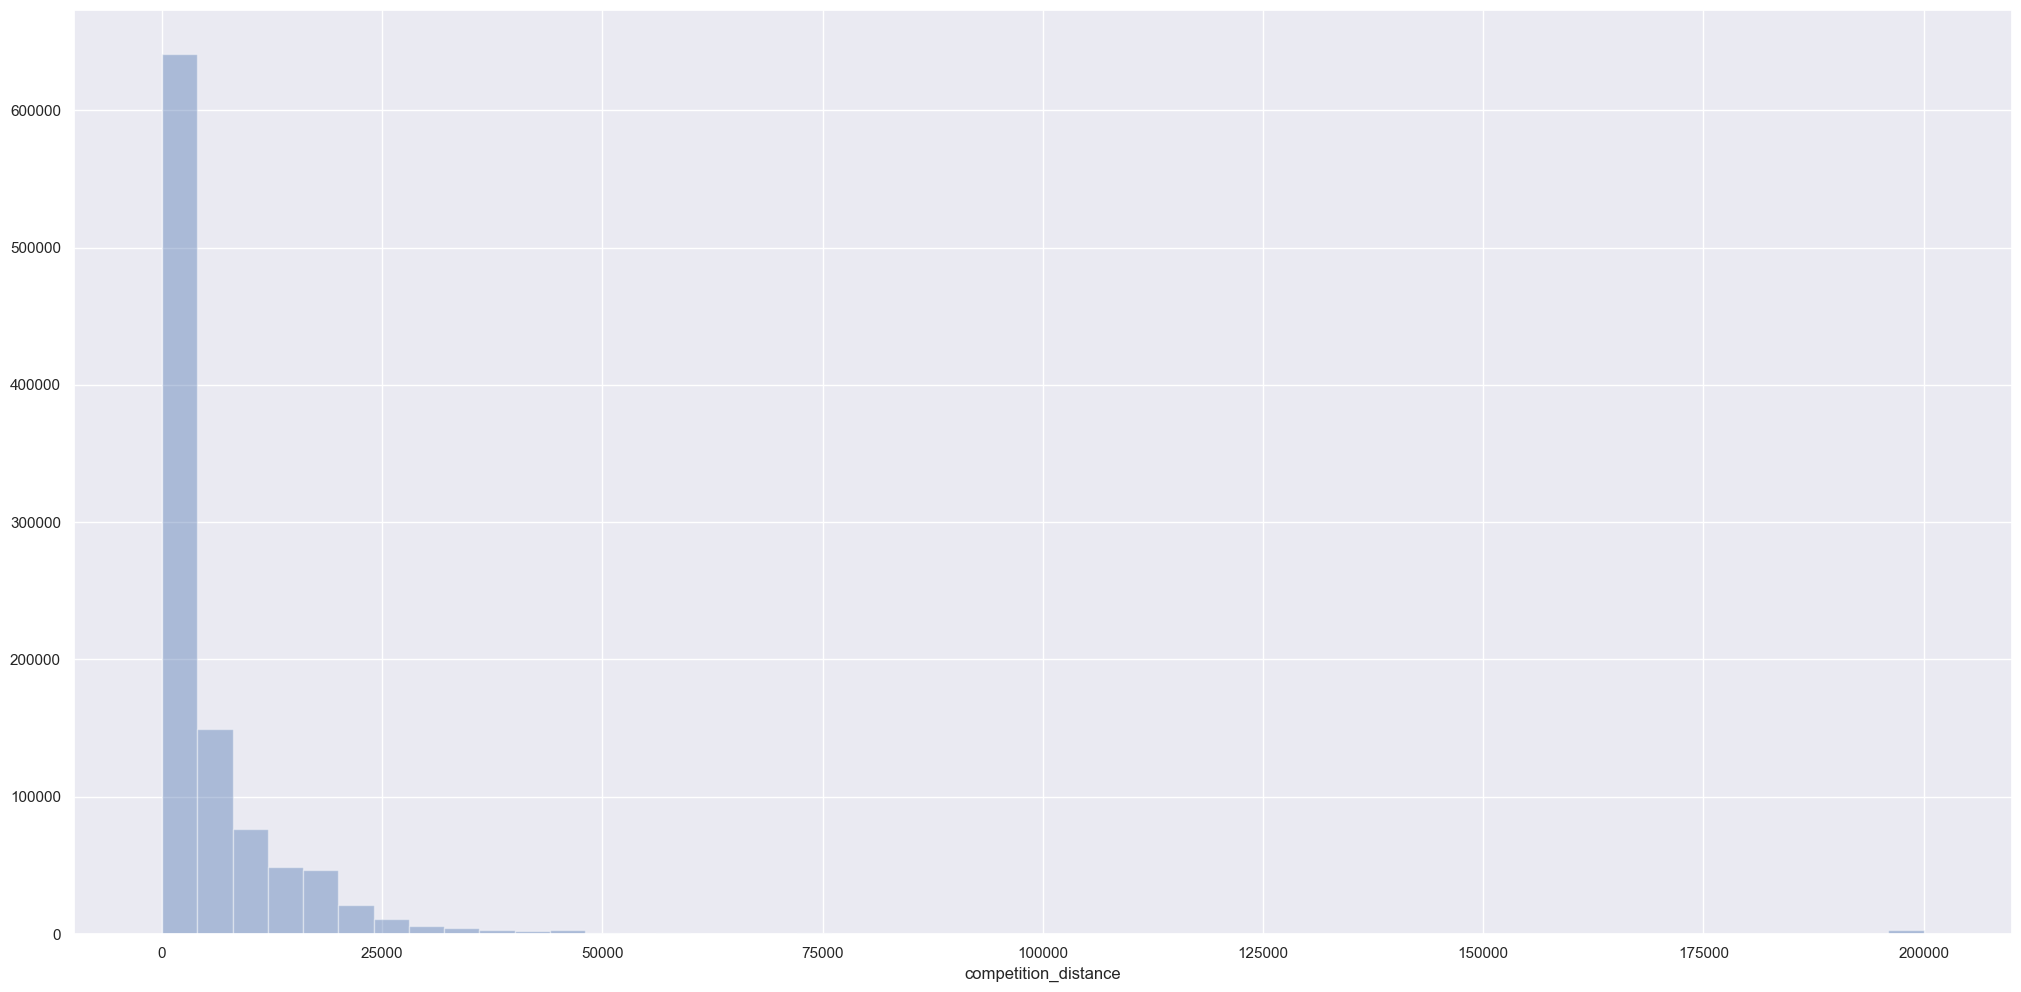

In [21]:
sns.distplot( df1['competition_distance'], kde=False );

### 1.7.2 Categorical Attributes

In [22]:
#cat_attributes.apply(lambda x: x.unique().shape[0])

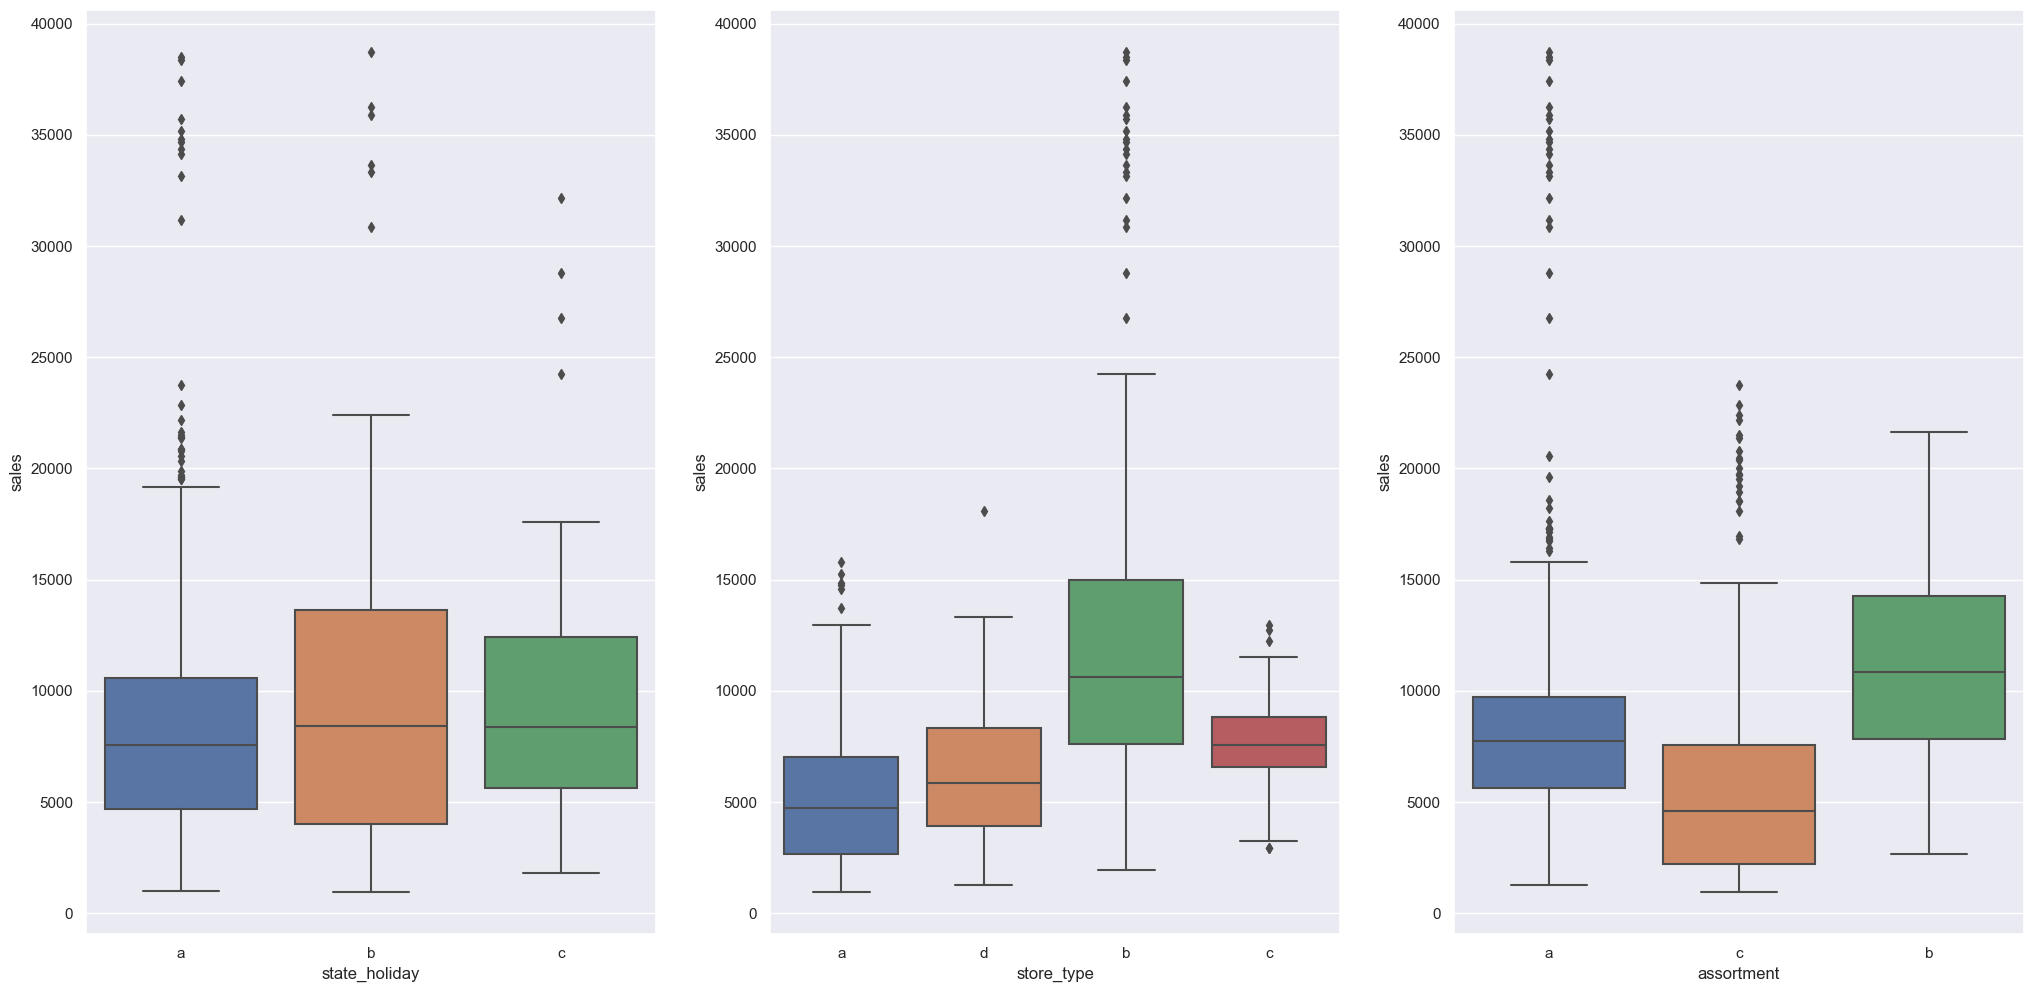

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

pt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y='sales' ,data = aux1);

pt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y='sales' ,data = aux1);

pt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y='sales' ,data = aux1);


In [24]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 2.0. PASSO 02 -  FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipotese

In [26]:
df2 =df1.copy()

In [27]:
df2['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

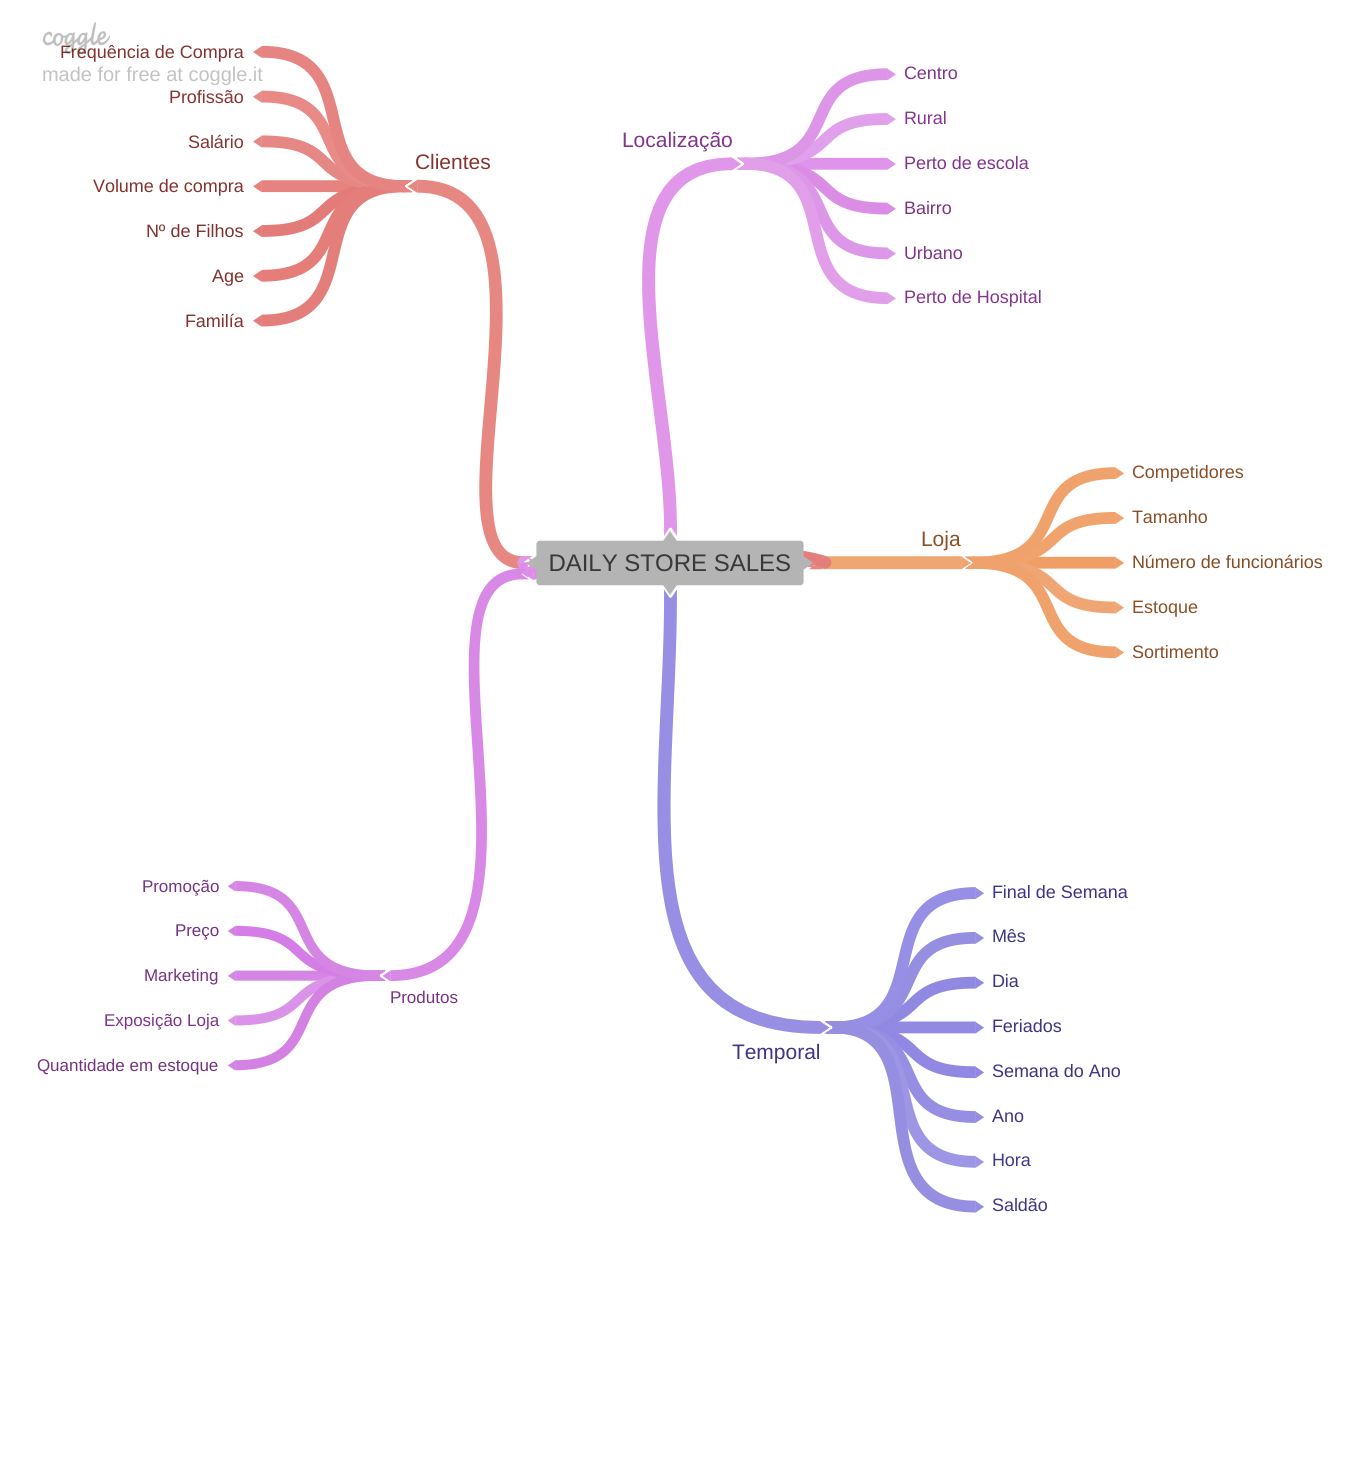

In [28]:
Image('/home/leticia/Documentos/comunidade_ds/ds_producao/img/MindMapHypothesis.png')

## 2.2 Criação de Hipotese - 


- Não é causa e efeito .

### 2.2.1 - Hipotese da Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com menosr porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores á mais tempo deveriam vender mais.


### 2.2.2 - Hipotese do Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe produtos na itrine deveriam mais.

**3.** Lojas que tem preço menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressiva (descontos maiores) , deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com maior numero de promoções consecutivas deveriam vender mais 

### 2.2.3 - Hipotese Temporal 

**1.** Lojas no feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos. 

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de seman 

**6.** Lojas deveriam vender menos durante feriados escolares.

### 2.2.4 -Lista de Hipótese 

- Você ira selecionar dados que você possui naquele momento . Vai priorizar os dados que você possui

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com maior sortimento deveriam vender mais.

**3.** Lojas com competidores á mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com maior numero de promoções consecutivas deveriam vender mais 

**7.** Lojas no feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos. 

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de seman 

**12.** Lojas deveriam vender menos durante feriados escolares.



## 2.3. Feature Engineering

In [29]:
# year
df2['year']= df2['date'].dt.year


# month
df2['month']= df2['date'].dt.month

# day
df2['day']= df2['date'].dt.day

# week of year
df2['week_of_year']= df2['date'].dt.isocalendar().week

# year week

df2['year_week']= df2['date'].dt.strftime('%Y-%W')

# competition since( tenho o mês e o ano separado vou ter que unir )

df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day = 1), axis = 1)
df2['competition_time_mont']= ((df2['date']- df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x + '-1','%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x == 'b'  else  'extended')

#stateHoliday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day'   )

In [30]:
df2['state_holiday']. unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [31]:
df2.head().T


,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [32]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [33]:
df3 = df2.copy()

## 3.1.Filtragem das Linhas

In [34]:
df3 = df3[(df3['open'] != 0) &(df3['sales'] > 0)]
           

## 3.2. Seleção de Colunas

In [35]:
cols_drop =['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_mont', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 4- ANALISE EXPLORATORIA DOS DADOS - EDA

- Ganhar experiencia de negocio:

Ex:saber como o negócio funciona, como as lojas se comporta, o tipo de mercadorias, os periodos que possui mais vendas 

- Validar as hipoteses

Para analisar os dados e ver como as hipotese criadas funciona 
ex: Gerando insights( uma supresa falando uma coisa que a pessoa nunca tinha visto antes e segundo é quando você mostra dados para confrontar pensamentos o achismo das pessoas ) 

- Quais são as variáveis importante para o modelo 

Analisar as variáveis , não somente elas sozinha e ver as correlações com outras variáveis 

In [37]:
df4= df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Response Variable

<Axes: xlabel='sales'>

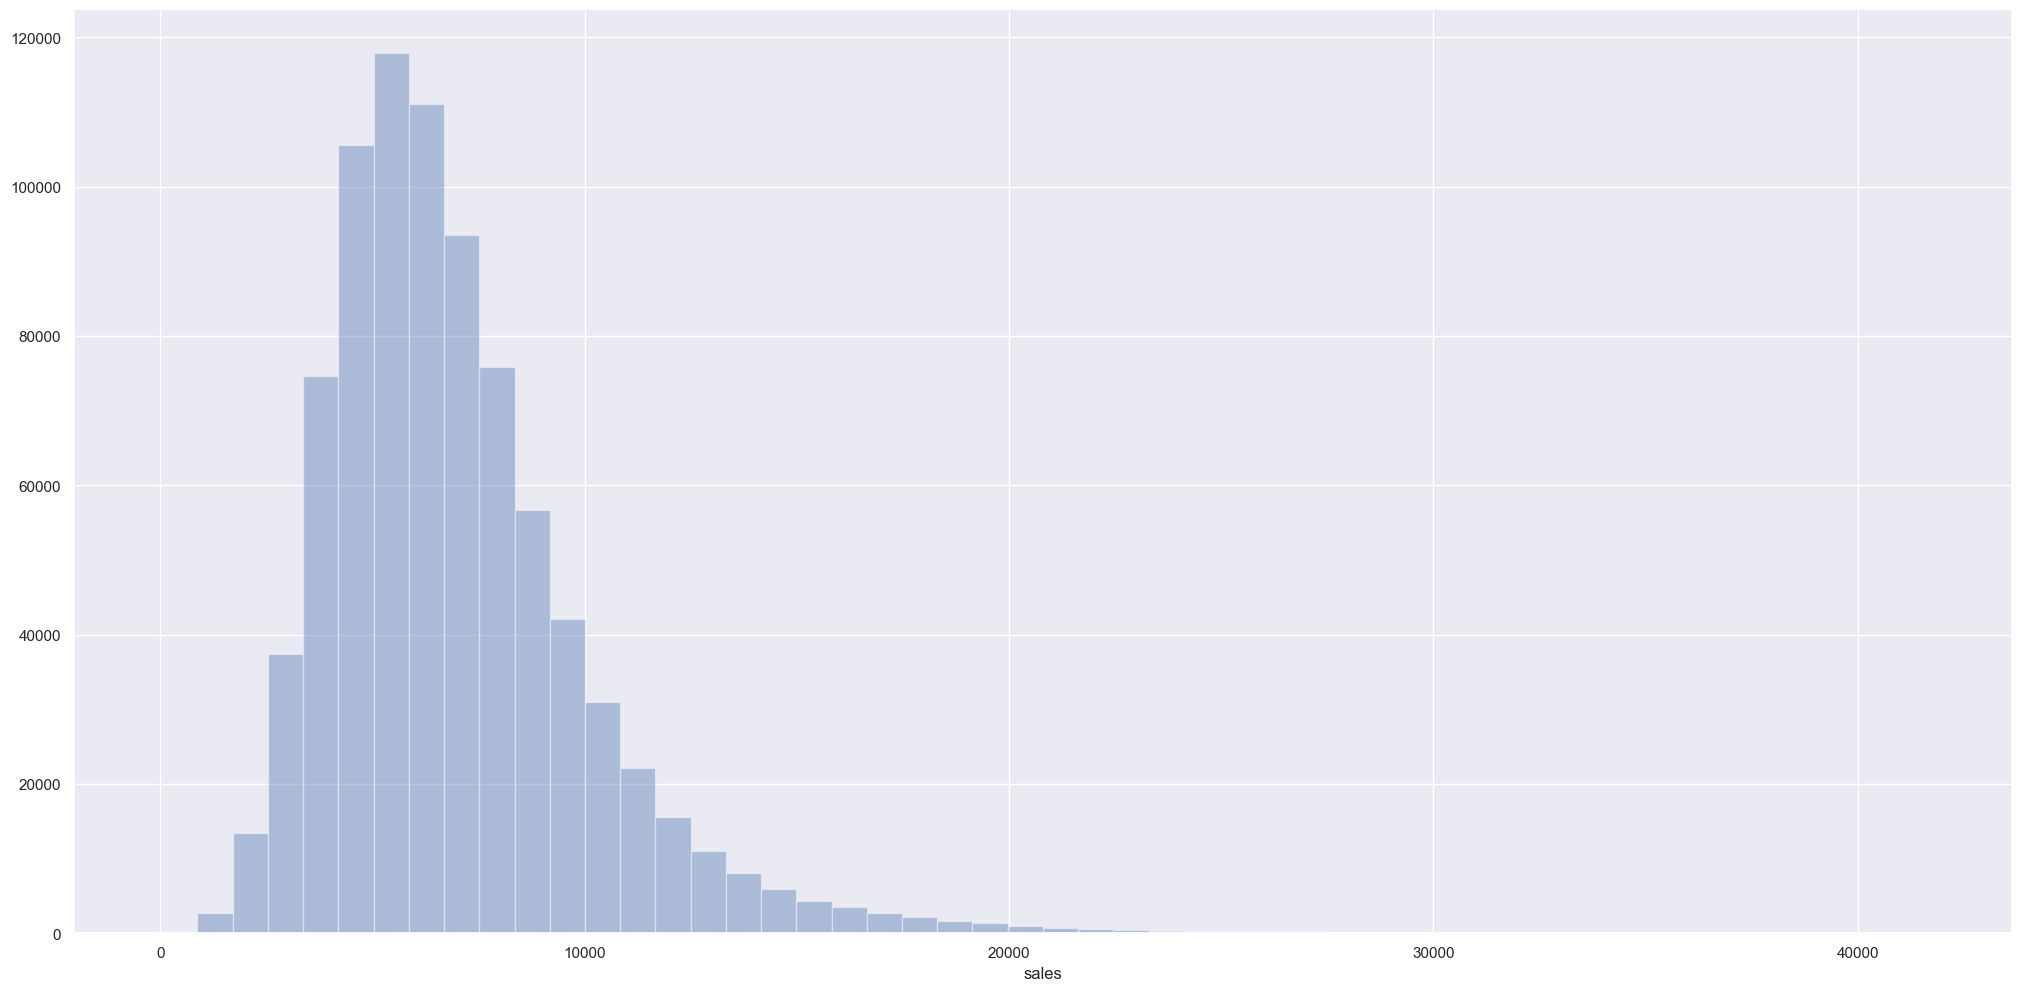

In [38]:
sns.distplot(df4['sales'],kde= False)


### 4.1.2 Numerical Variable

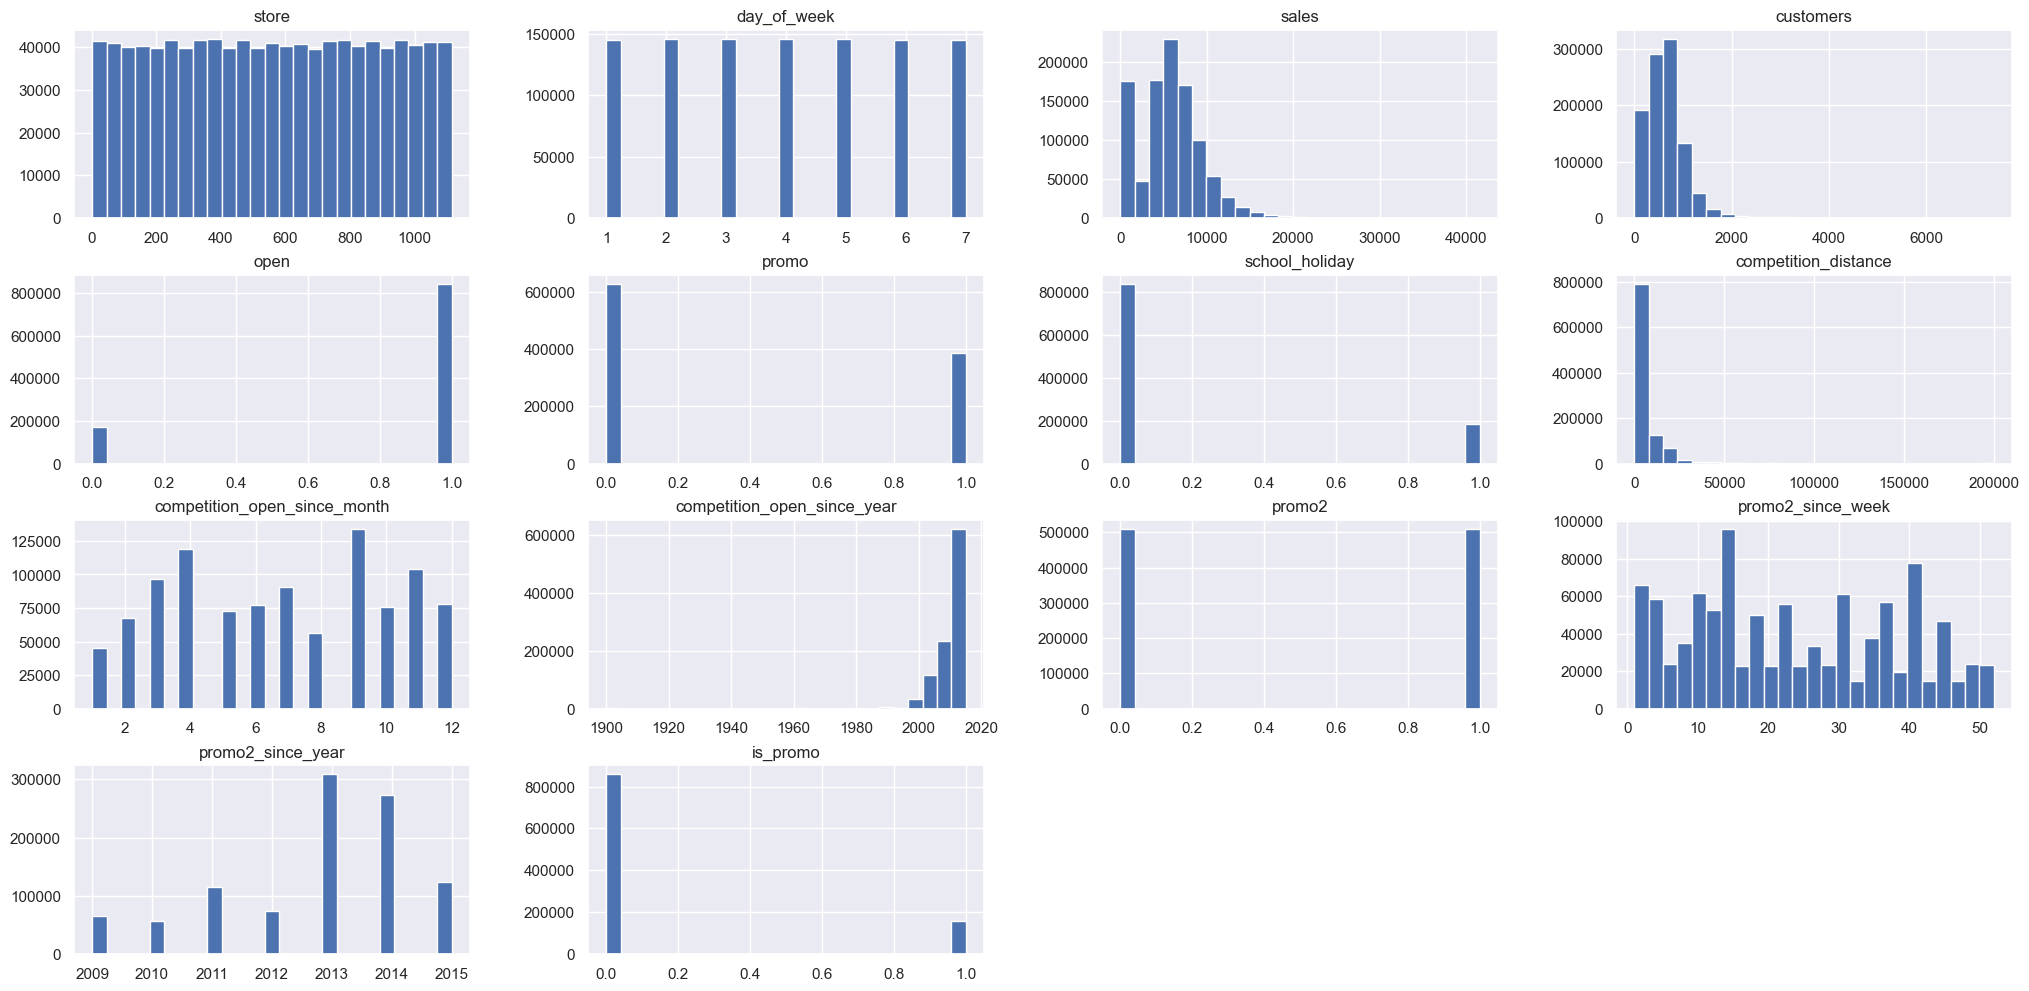

In [39]:
# descreve o comportamento da variável. Quanto mais comportamento a variavel tem é se torna mais explicativa.
num_attributes.hist(bins=25);


### 4.1.3 Categorical Variable

In [40]:
#contar quantas linhas / vendas que eu tenho na minha vareavel categorica utilizadno meu atributo de vendas
cat_attributes.head()



,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [41]:
#para identificar com as categoricas originais 
df4['state_holiday'].drop_duplicates()



0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [42]:
#para identificar os tipo de store_type

df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [43]:
#para identificar os tipo de assortment
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

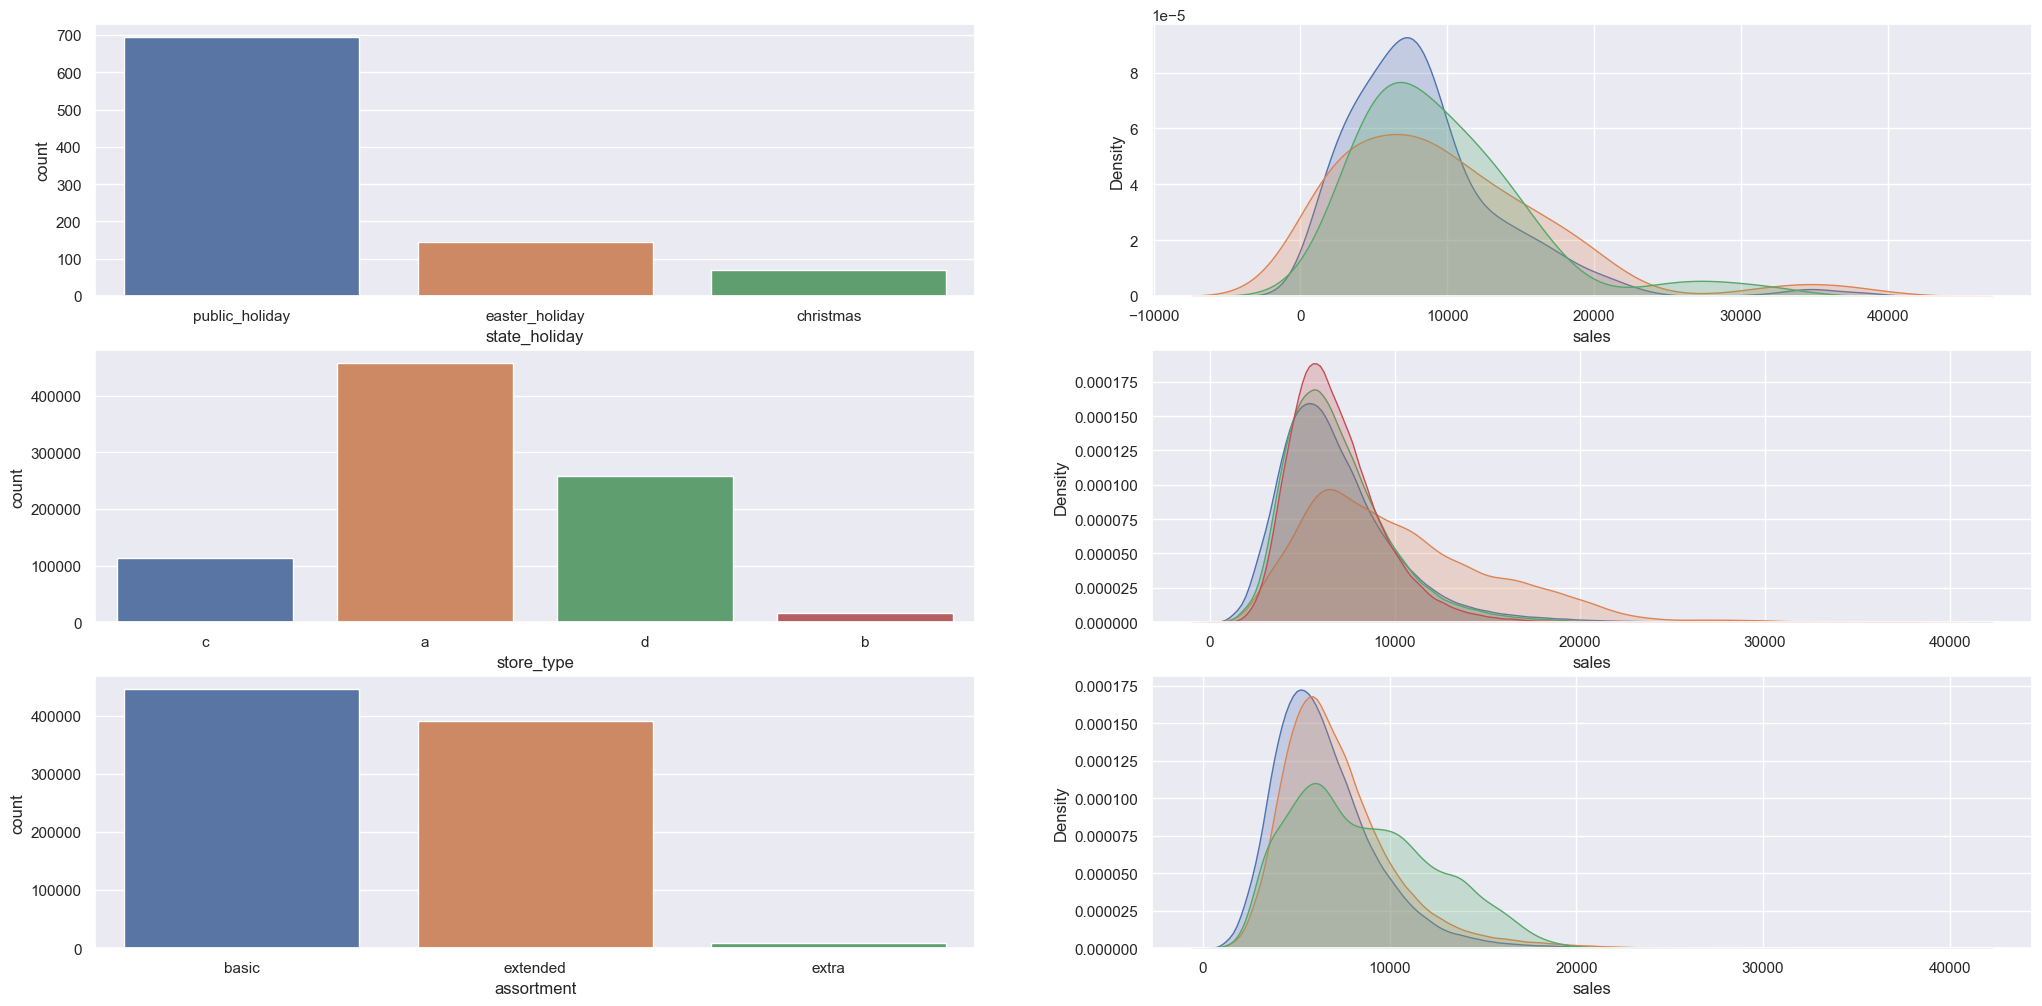

In [44]:
#state_holiday( vamos contar e saber qual o tipo de feriado que impacta mais )
#contar todos os feriados

#state_holiday
#esse código gera um gráfico de densidade de probabilidade para as vendas (sales) que 
#ocorrem durante feriados públicos (public_holiday) no dataframe df4. A curva de 
#densidade mostra a estimativa de como as vendas se distribuem nesses dias.

pt.subplot(3,2,1)
dt_aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data= dt_aux)

pt.subplot(3,2,2)
ph=df4[df4['state_holiday']== 'public_holiday']['sales']
eh=df4[df4['state_holiday']== 'easter_holiday']['sales']
ch=df4[df4['state_holiday']== 'christmas']['sales']

sns.kdeplot(ph,label ='public_holiday',shade =True)
sns.kdeplot(eh,label ='easter_holiday',shade =True)
sns.kdeplot(ch,label ='christmas',shade =True)


#store_type

pt.subplot(3,2,3)
sns.countplot(x='store_type', data= df4)

pt.subplot(3,2,4)
aux1=df4[df4['store_type']== 'a']['sales']
aux2=df4[df4['store_type']== 'b']['sales']
aux3=df4[df4['store_type']== 'c']['sales']
aux4=df4[df4['store_type']== 'd']['sales']

sns.kdeplot(aux1,label ='a',shade =True)
sns.kdeplot(aux2,label ='b',shade =True)
sns.kdeplot(aux3,label ='c',shade =True)
sns.kdeplot(aux4,label ='d',shade =True)



#assorment assortment

pt.subplot(3,2,5)
sns.countplot(x='assortment', data= df4)

pt.subplot(3,2,6)
aux1=df4[df4['assortment']== 'basic']['sales']
aux2=df4[df4['assortment']== 'extended']['sales']
aux3=df4[df4['assortment']== 'extra']['sales']

sns.kdeplot(aux1,label ='basic',shade =True)
sns.kdeplot(aux2,label ='extended',shade =True)
sns.kdeplot(aux3,label ='extra',shade =True)



## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

***FALSA**

- essa hipotese esta errada analisando os gráficos vemos os comportamento de tipos de lojas e a quantidade de vendas , lojas com assortmente basic e extranded são as que possui maiores quantidade de vendas ,ja as lojas com tipo de assortement extra tem a menor quantidade de vendas.

-

<Axes: xlabel='year_week'>

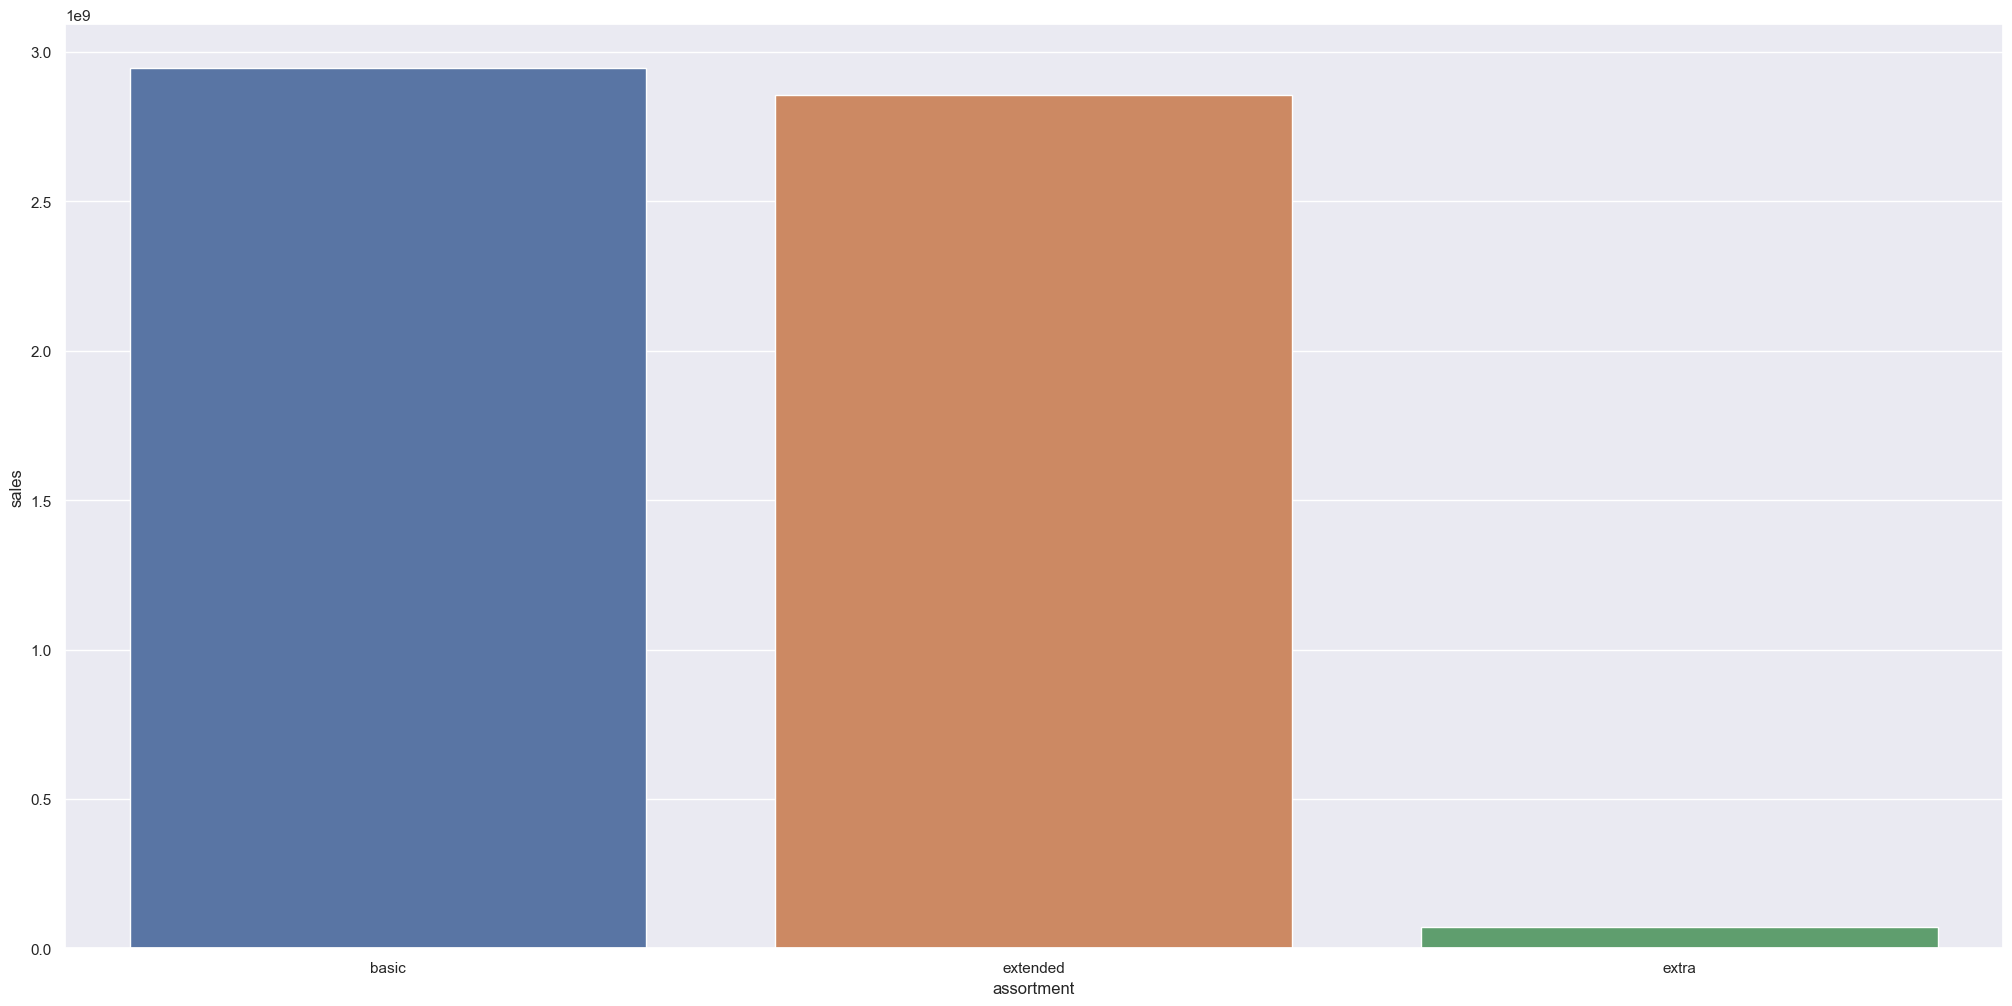

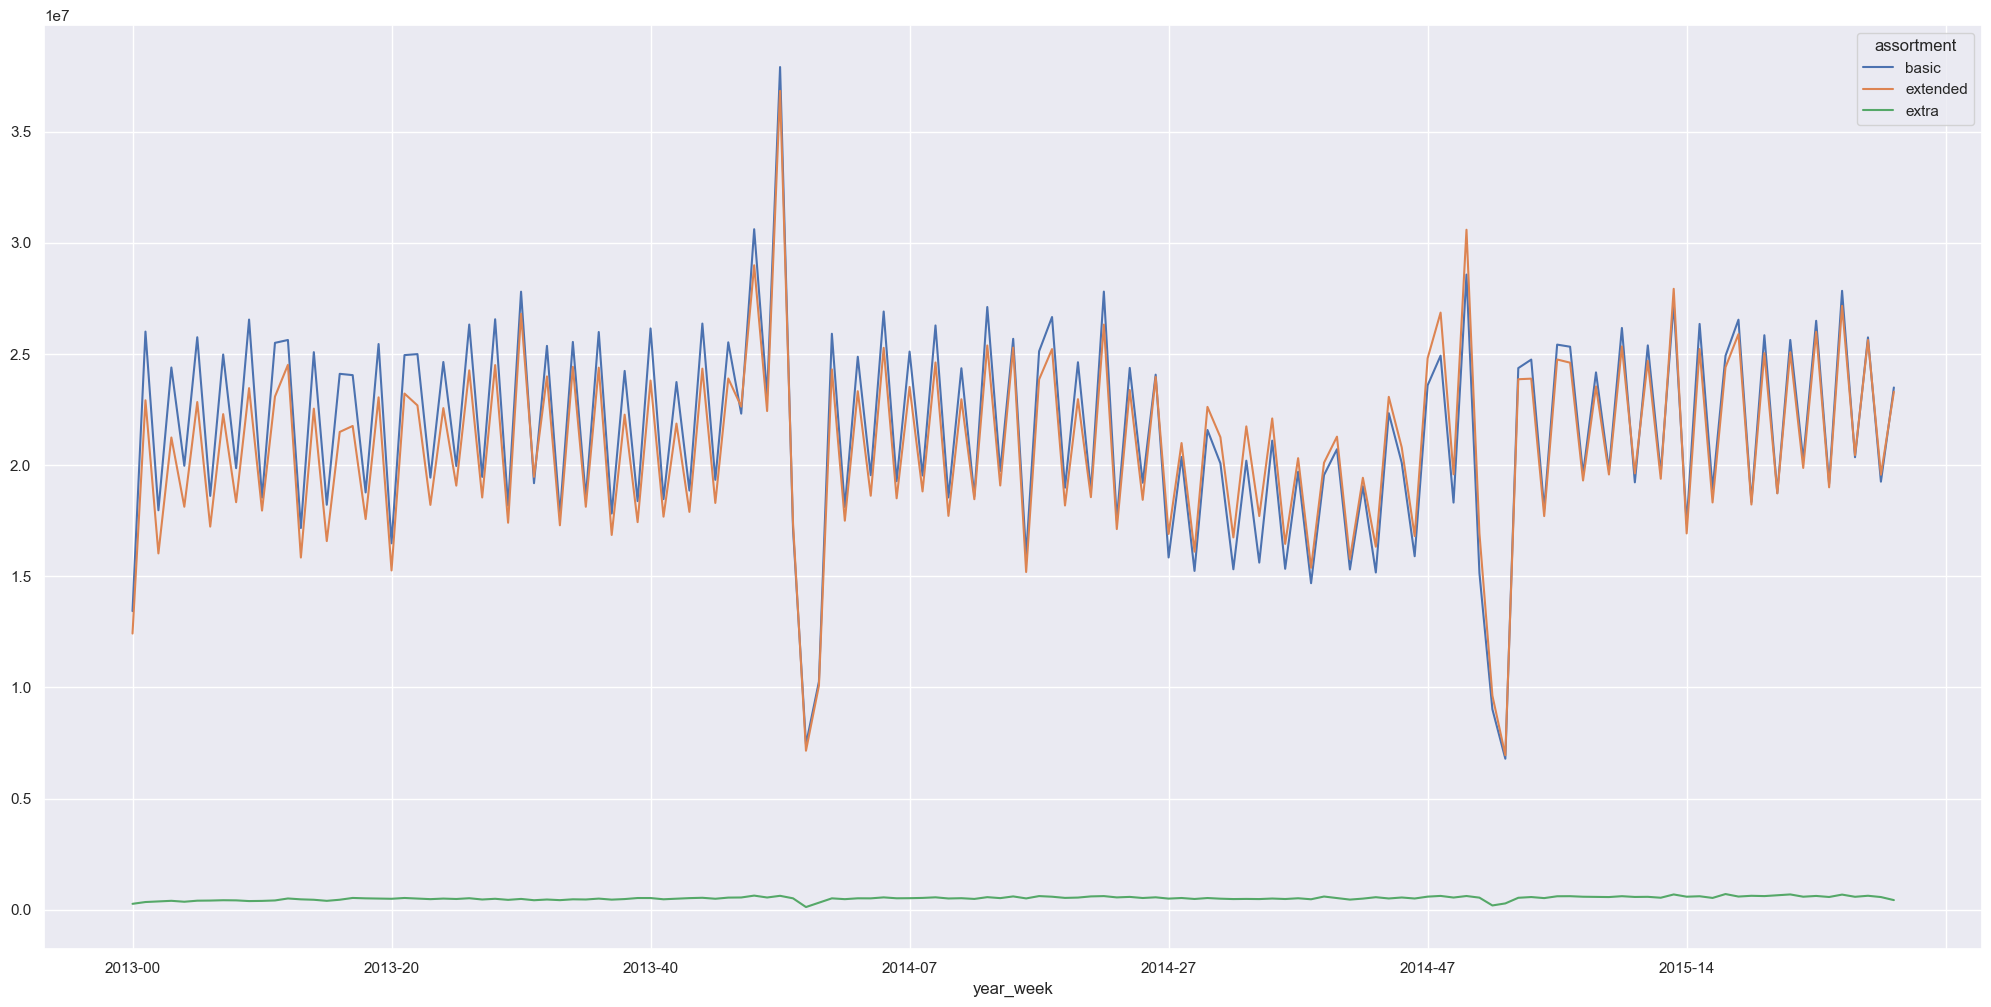

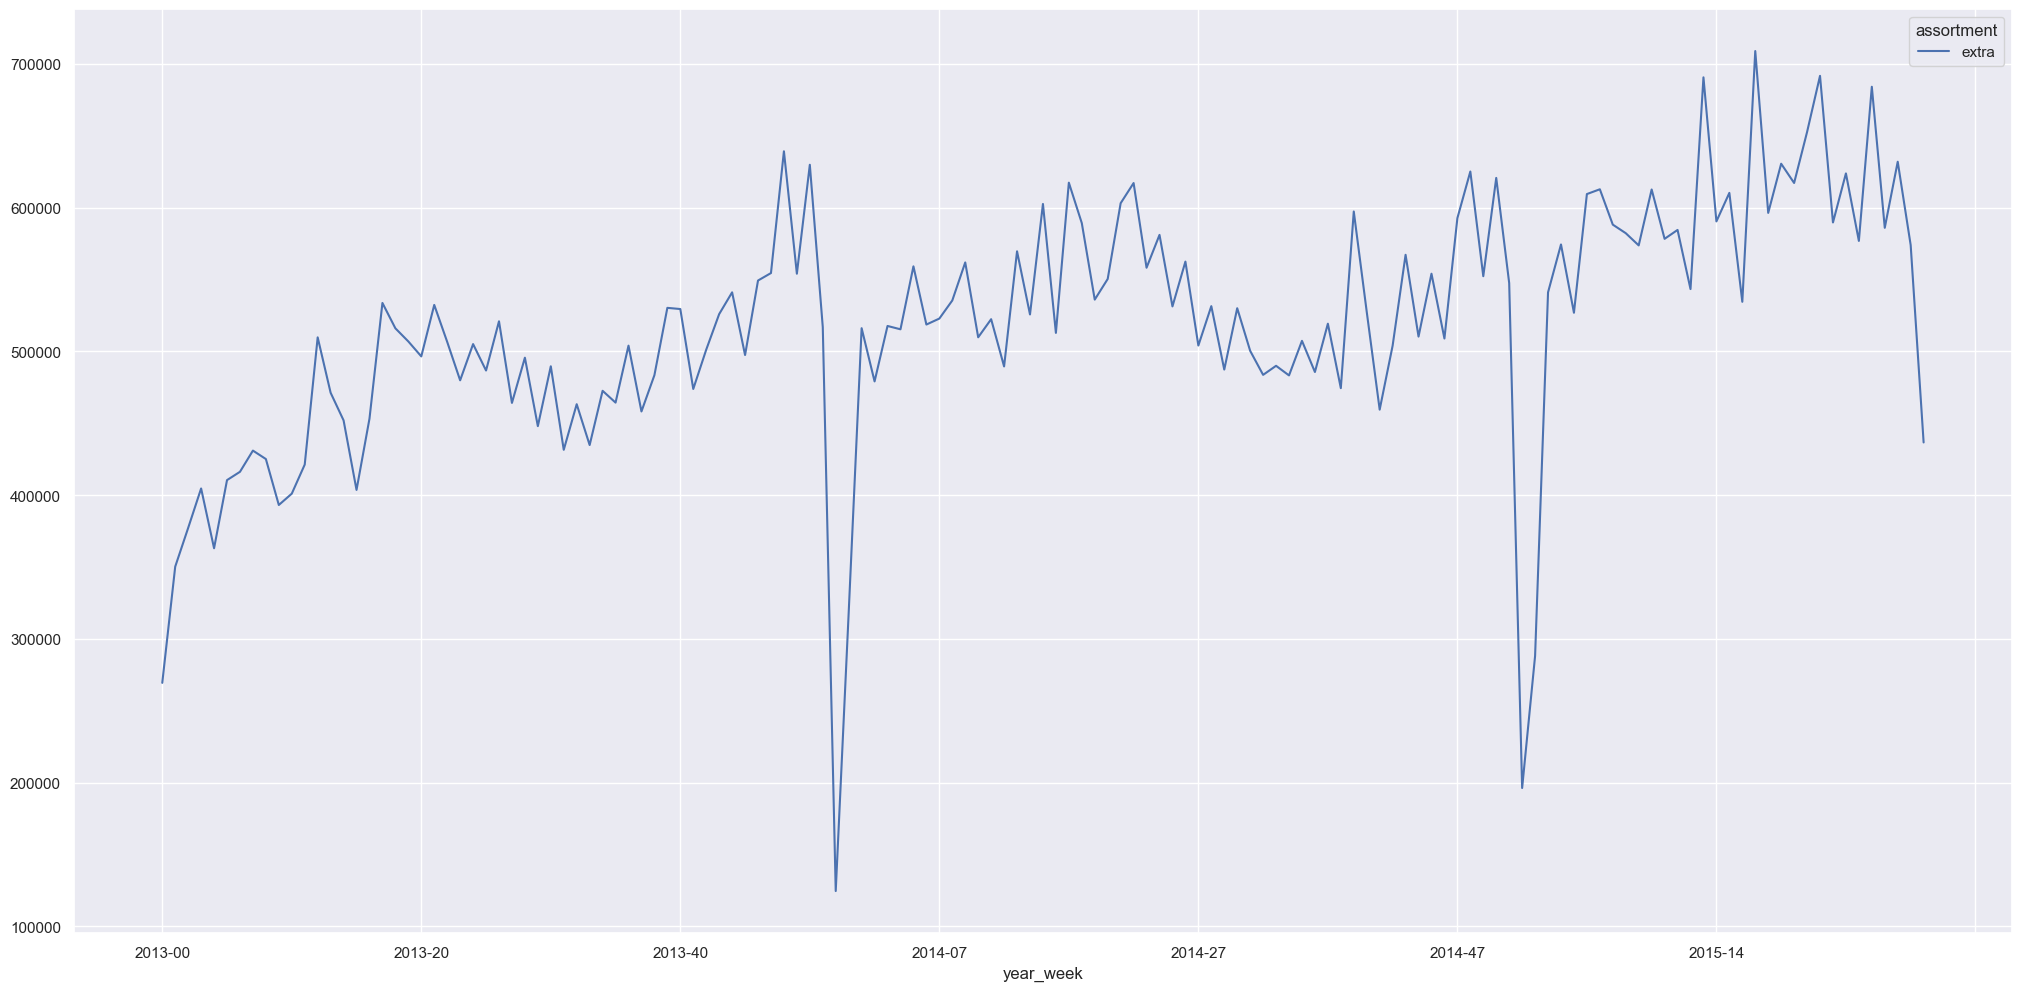

In [45]:
# Quantidade de tipos de produtos('assortment') que a loja pode oferecer com a 
#variavel resposta ('sales')
aux10 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment',y='sales',data=aux10);

#podemos obsevar aqui no grafico que as lojas possui mais quantidade de vendas
#são o basic e o extended
#Então podemos dizer que essa hipotese é falsa pq lojas com opções extras vende menos 

aux11 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux11.pivot( index='year_week', columns='assortment',values='sales').plot()

#separando a o comportamento pelo tipo de vendas 'extra', para podemos ver o comportamento dela junto com as
#demais parece ser de forma linear ,mas sepradamente ela tem picos é completamente diferente;
#quando vermos um comportamento assim é de boa pratica analisar ele de forma separada para ver o comportamento ;
aux12=aux11[aux11['assortment']== 'extra']
aux12.pivot( index='year_week', columns='assortment',values='sales').plot()        

In [46]:
aux11

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
5,2013-01,extra,350279
6,2013-02,basic,17970974
7,2013-02,extended,16029584
8,2013-02,extra,377207
9,2013-03,basic,24392076


### H2. Lojas com competidores mais proximos deveriam vender menos .
**FALSA**



- Podemos olhar aqui com essas dados que quanto mais próximo os meus competidores maior é o meu numero de venda

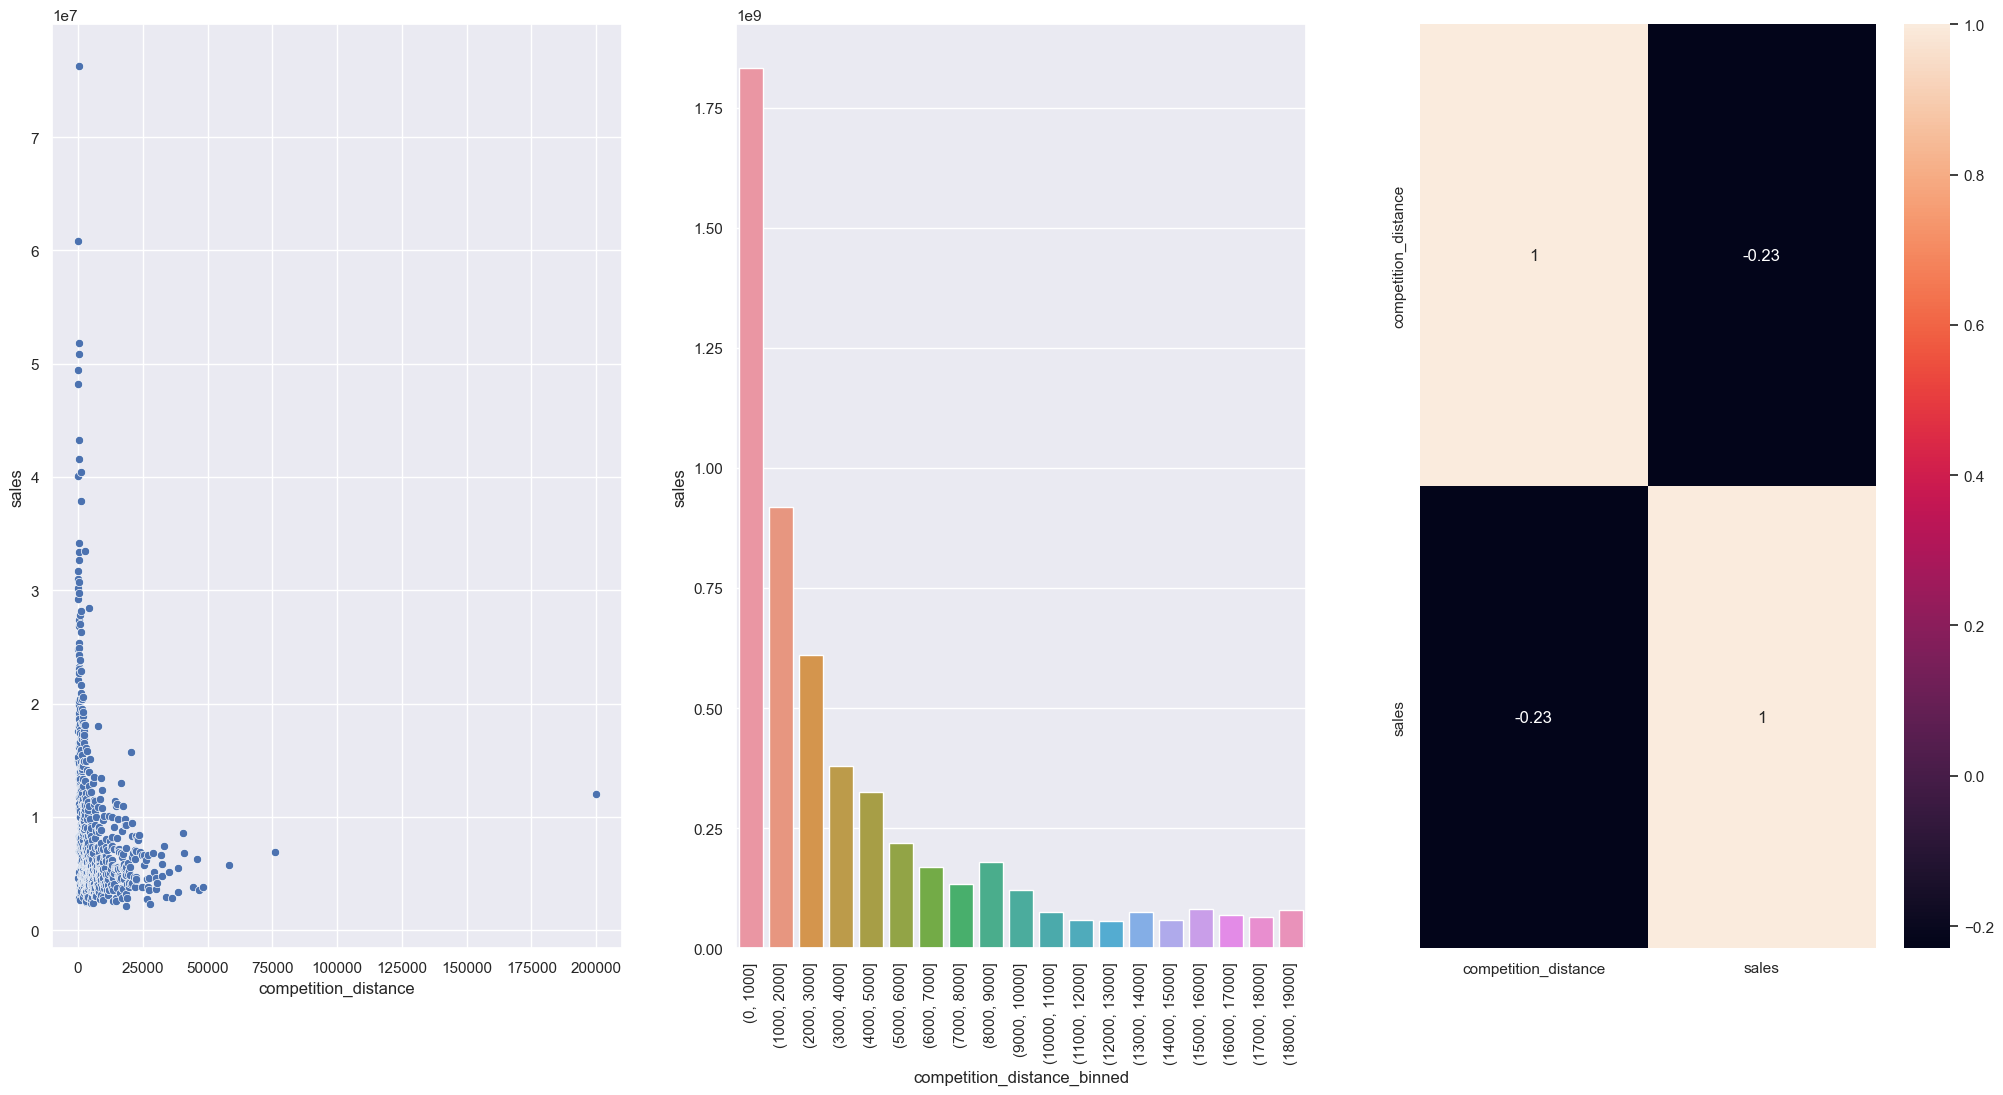

In [47]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()


pt.subplot(1,3,1)
#Criando grafico para melhor visualisação graficos de pontos , podemos ver que toda a concentração esta ligada a lojas que tem competidor mais próximo
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

# para melhor agregar vamos utilizar o bin para agregar quantidade cde valores dentro de grupos
pt.subplot(1,3,2)
bins=list(np.arange(0,20000, 1000) )
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

#rotacionando a legenda do grafico em 90º
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
pt.xticks(rotation=90);

#força da correlação ( ela vai de 1 até -1 , quanto mais proxima de 0  mais fraca é correlação, qto mais proximo de 1 mais forte é acorrelação  )
pt.subplot(1,3,3)
x= sns.heatmap(aux1.corr(method='pearson'), annot= True);


### H3.Lojas com competidores á mais tempo deveriam vender mais.
**FALSA**

-Quanto mais recente abrir um competior maior a chance de venda 

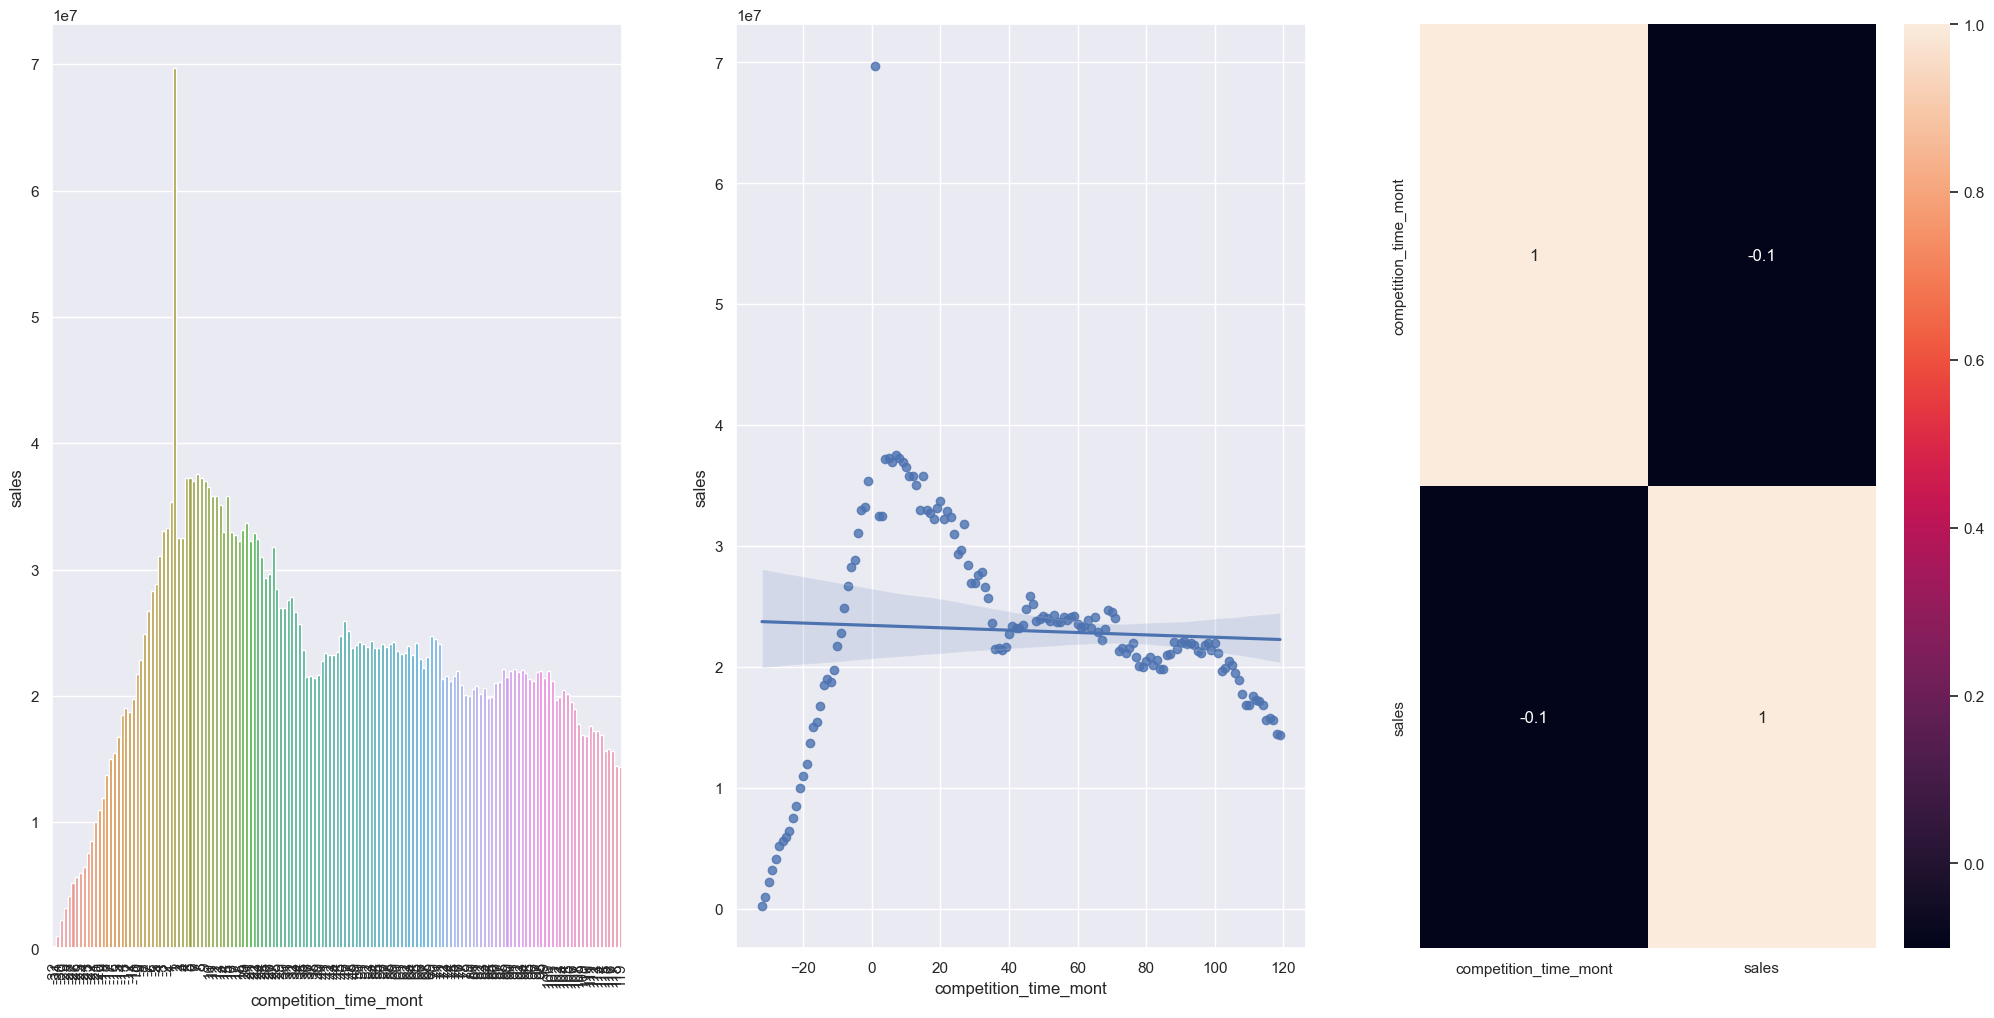

In [48]:
pt.subplot(1,3,1)
aux1= df4[['competition_time_mont','sales']].groupby('competition_time_mont').sum().reset_index()
aux2=aux1[(aux1['competition_time_mont']<120) & (aux1['competition_time_mont']!=0 )]
sns.barplot(x='competition_time_mont', y='sales',data= aux2);
pt.xticks(rotation=90);

pt.subplot(1,3,2)
sns.regplot(x='competition_time_mont', y='sales',data=aux2)

pt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'),annot= True);



In [49]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_mont', 'promo_since', 'promo_time_week'],
      dtype='object')

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** 

- Essa hipotese esta errada porque ao analisarmos os dados vemos o decaimento das vendas em lojas com longo periodo de promoçoes ativas

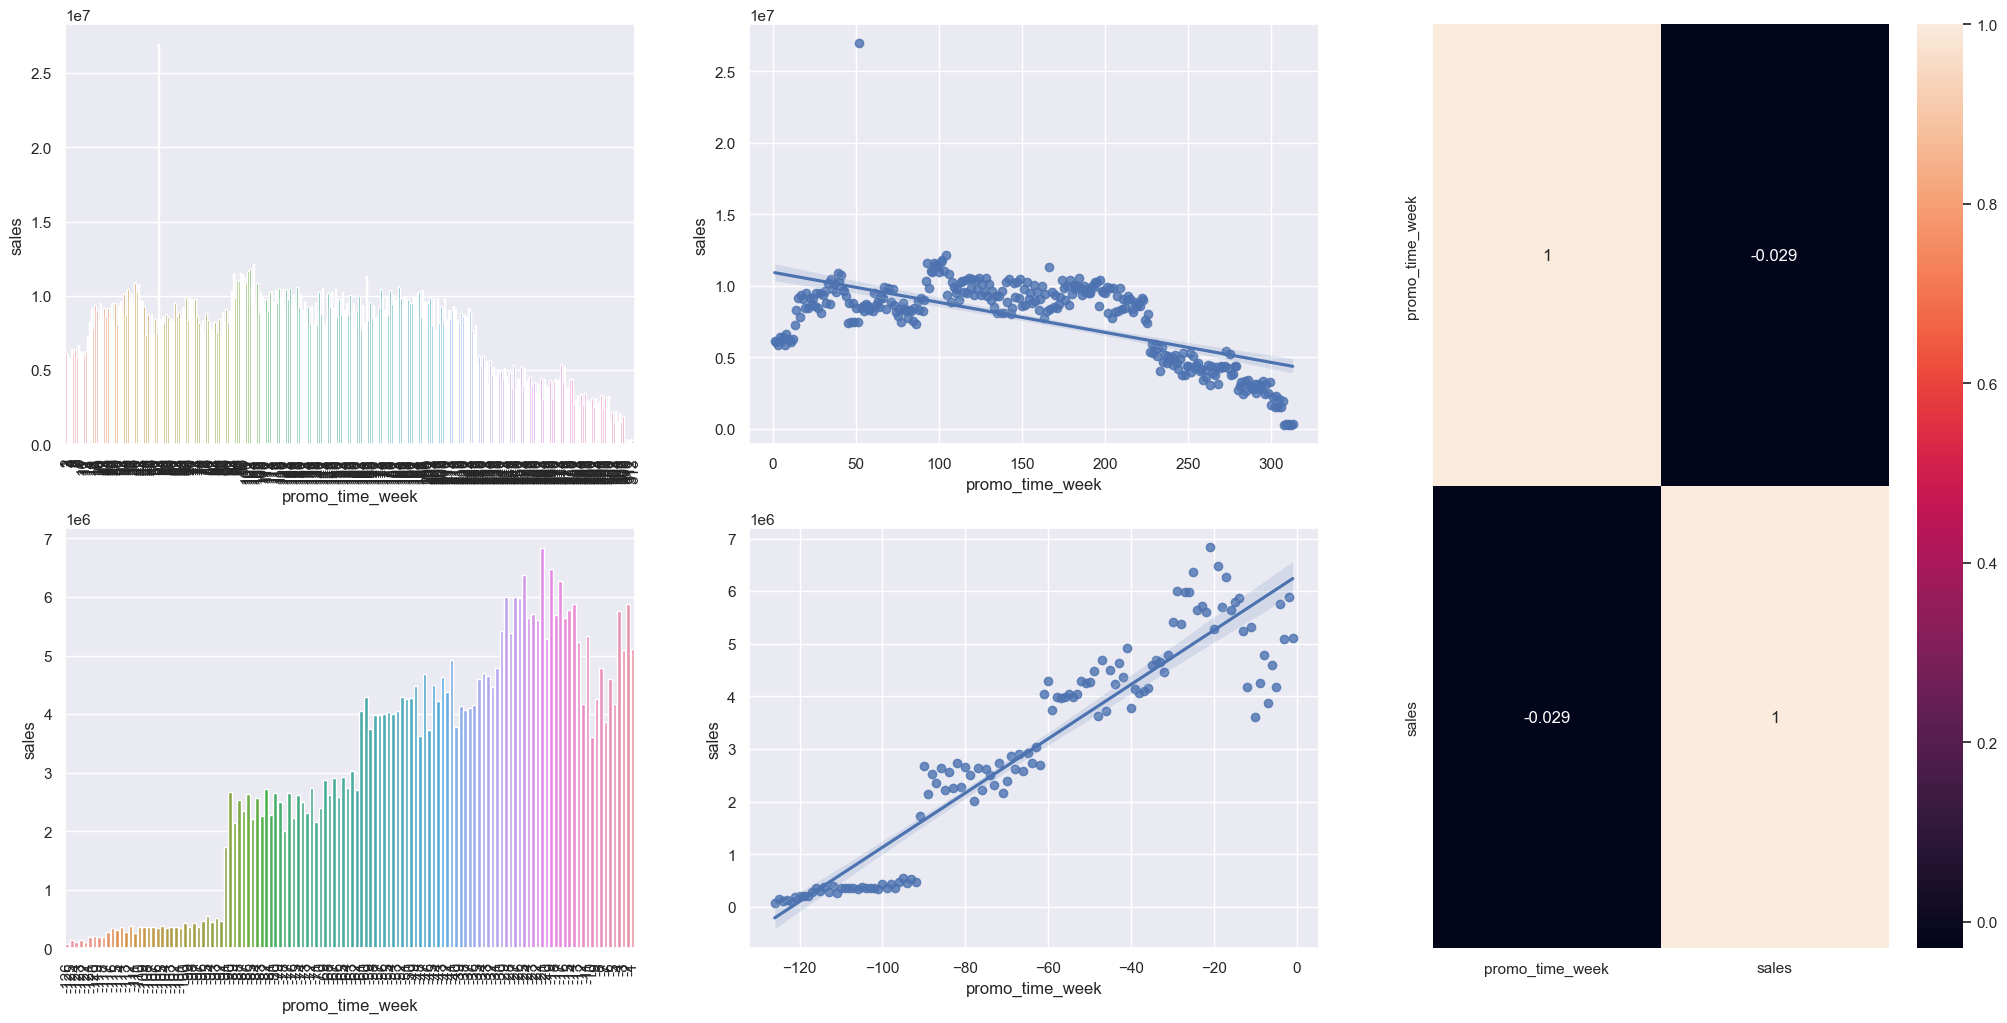

In [50]:
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2,3 )

pt.subplot(grid[0,0])
aux2= aux1[aux1['promo_time_week'] > 0 ] #promo extendido 
sns.barplot(x='promo_time_week', y='sales', data=aux2);
pt.xticks(rotation=90 );

pt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


pt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
pt.xticks(rotation=90 );

pt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

pt.subplot(grid[:,2])
#estou usando o aux11
x=sns.heatmap(aux1.corr(method='pearson'),annot= True);




-Para vizualizar melhor o grafico temos que realizar de um artificio matematico que é o corte desse grafico . Analisando que essa variavel tem dois periodo , olharemos de forma separa

-Temos uma correlaão muito fraca de 0,029 , ela não entra do modelo esta muito longe .

-utilizei a quebra para podermos olhar vizualizar melhor o algoritimo olha a coluna como todo 

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>



###  H6. Lojas com maior numero de promoções consecutivas deveriam vender mais
**False**

-Lojas com mais promo consecontiva vendem menos.
- Analisando os graficos abaixo podemos ver que com promoções extendida e promoção normal eles tem o mesmo comportamento , só possui o modelo de vendas menor. 

In [51]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


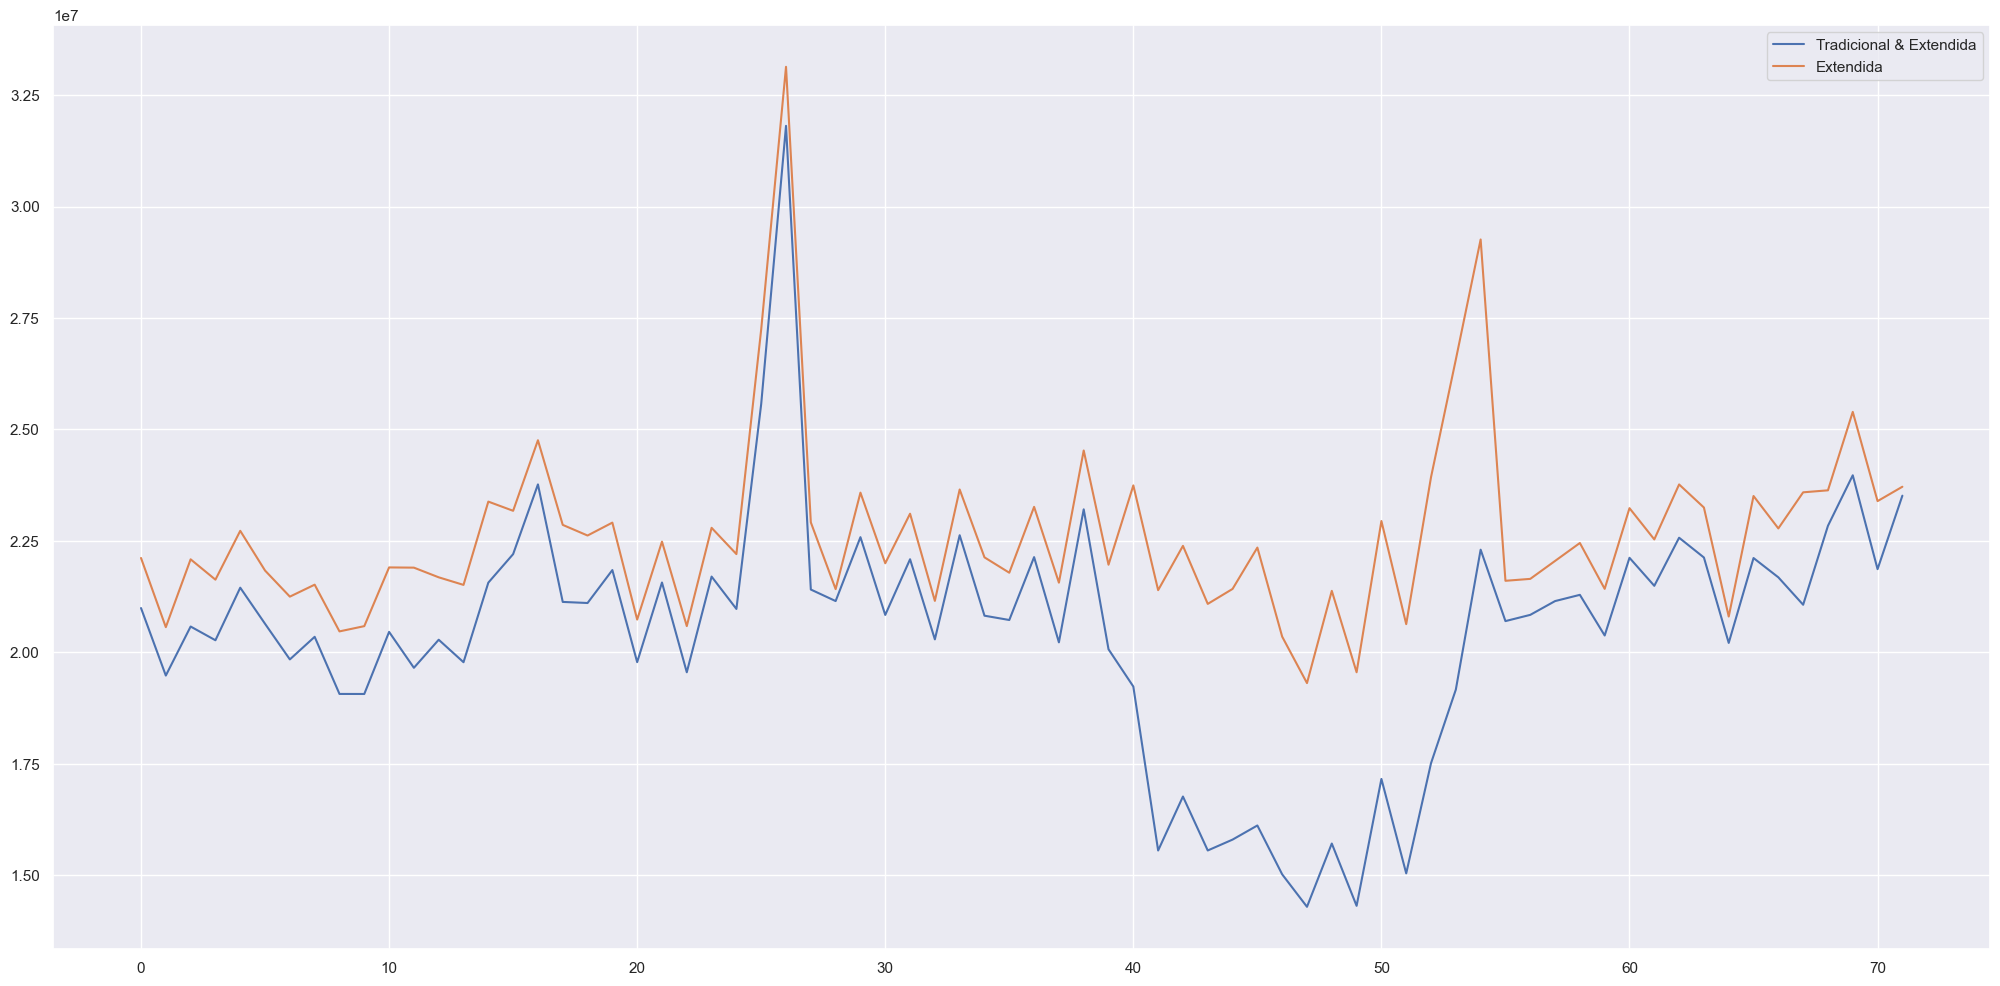

In [52]:

aux1 = df4[( df4['promo'] == 1 ) & ( df4 ['promo2'] == 1 )][['year_week','sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4 ['promo2'] == 0 )][['year_week','sales']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida' , 'Extendida']);


### H7. Lojas no feriado de natal deveriam vender mais.
**FALSO**


-lojas abertas nurante o feriado do natal vedem menos comparda com os demais feriados 

<Axes: xlabel='year', ylabel='sales'>

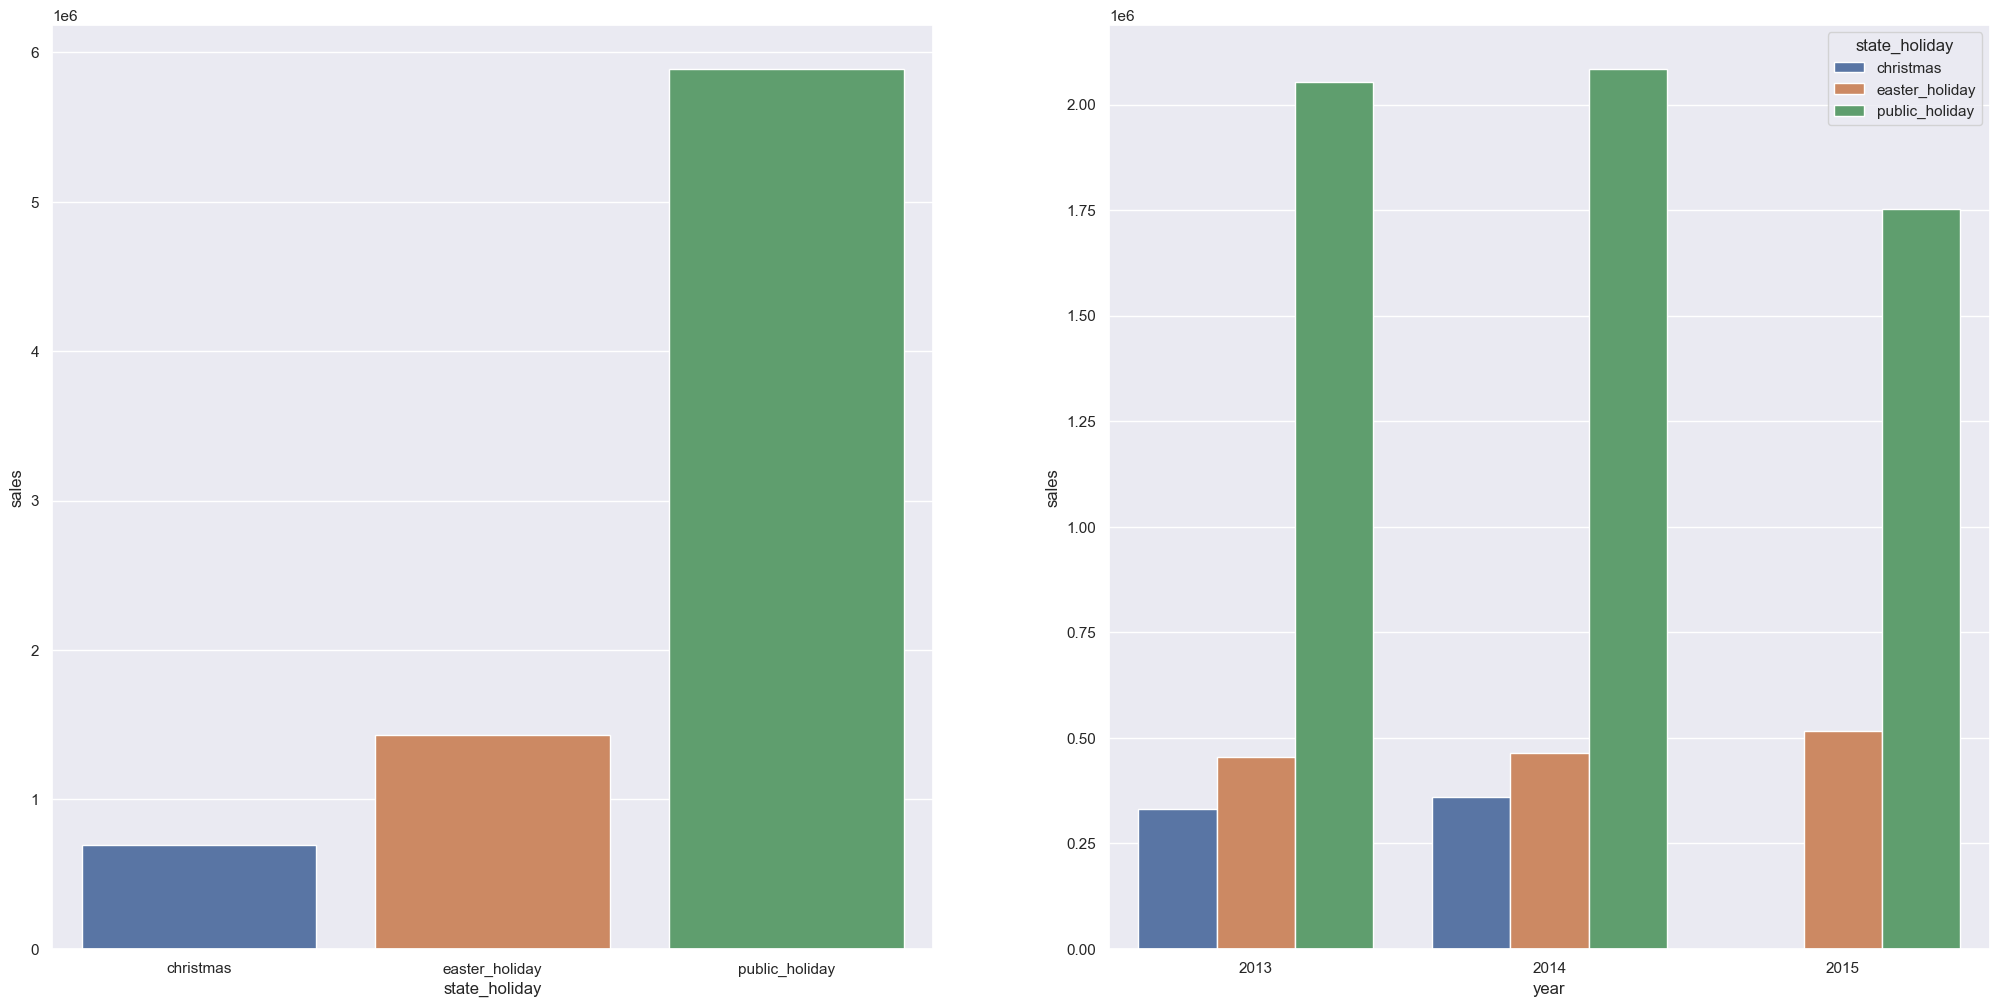

In [53]:
pt.subplot(1,2,1)
aux= df4[df4['state_holiday'] != 'regular_day']
aux1= aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y ='sales', data= aux1 )


pt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y ='sales',hue= 'state_holiday', data= aux2 )




### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSO**


- ao longo dos anos podemos observar que existe uma queda nas vendas.
- podemos observar essa queda e uma correlação forte por causa que temos o nao de 2015 sem esta completo 


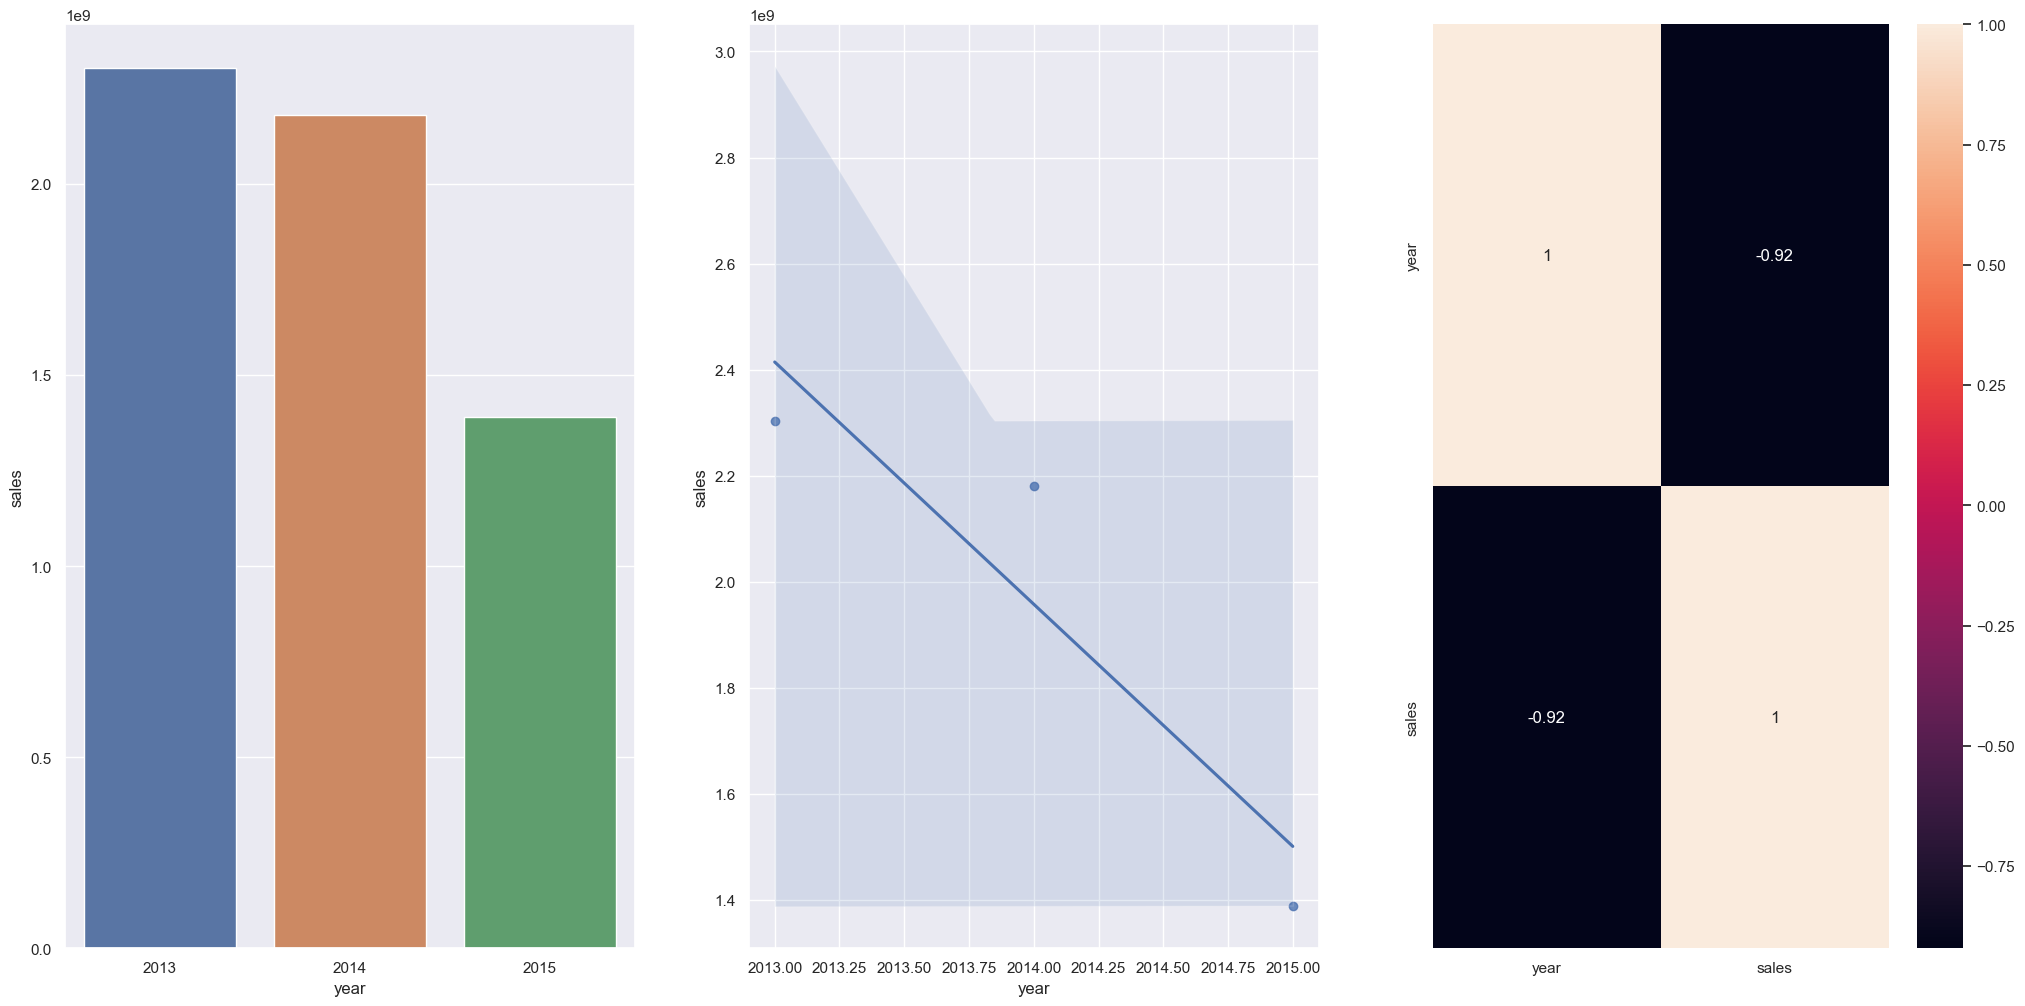

In [54]:
aux1=df4[['year','sales']].groupby('year').sum().reset_index()

pt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

pt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

pt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSO**


- as lojas vendem menos no segundo semestre do ano 

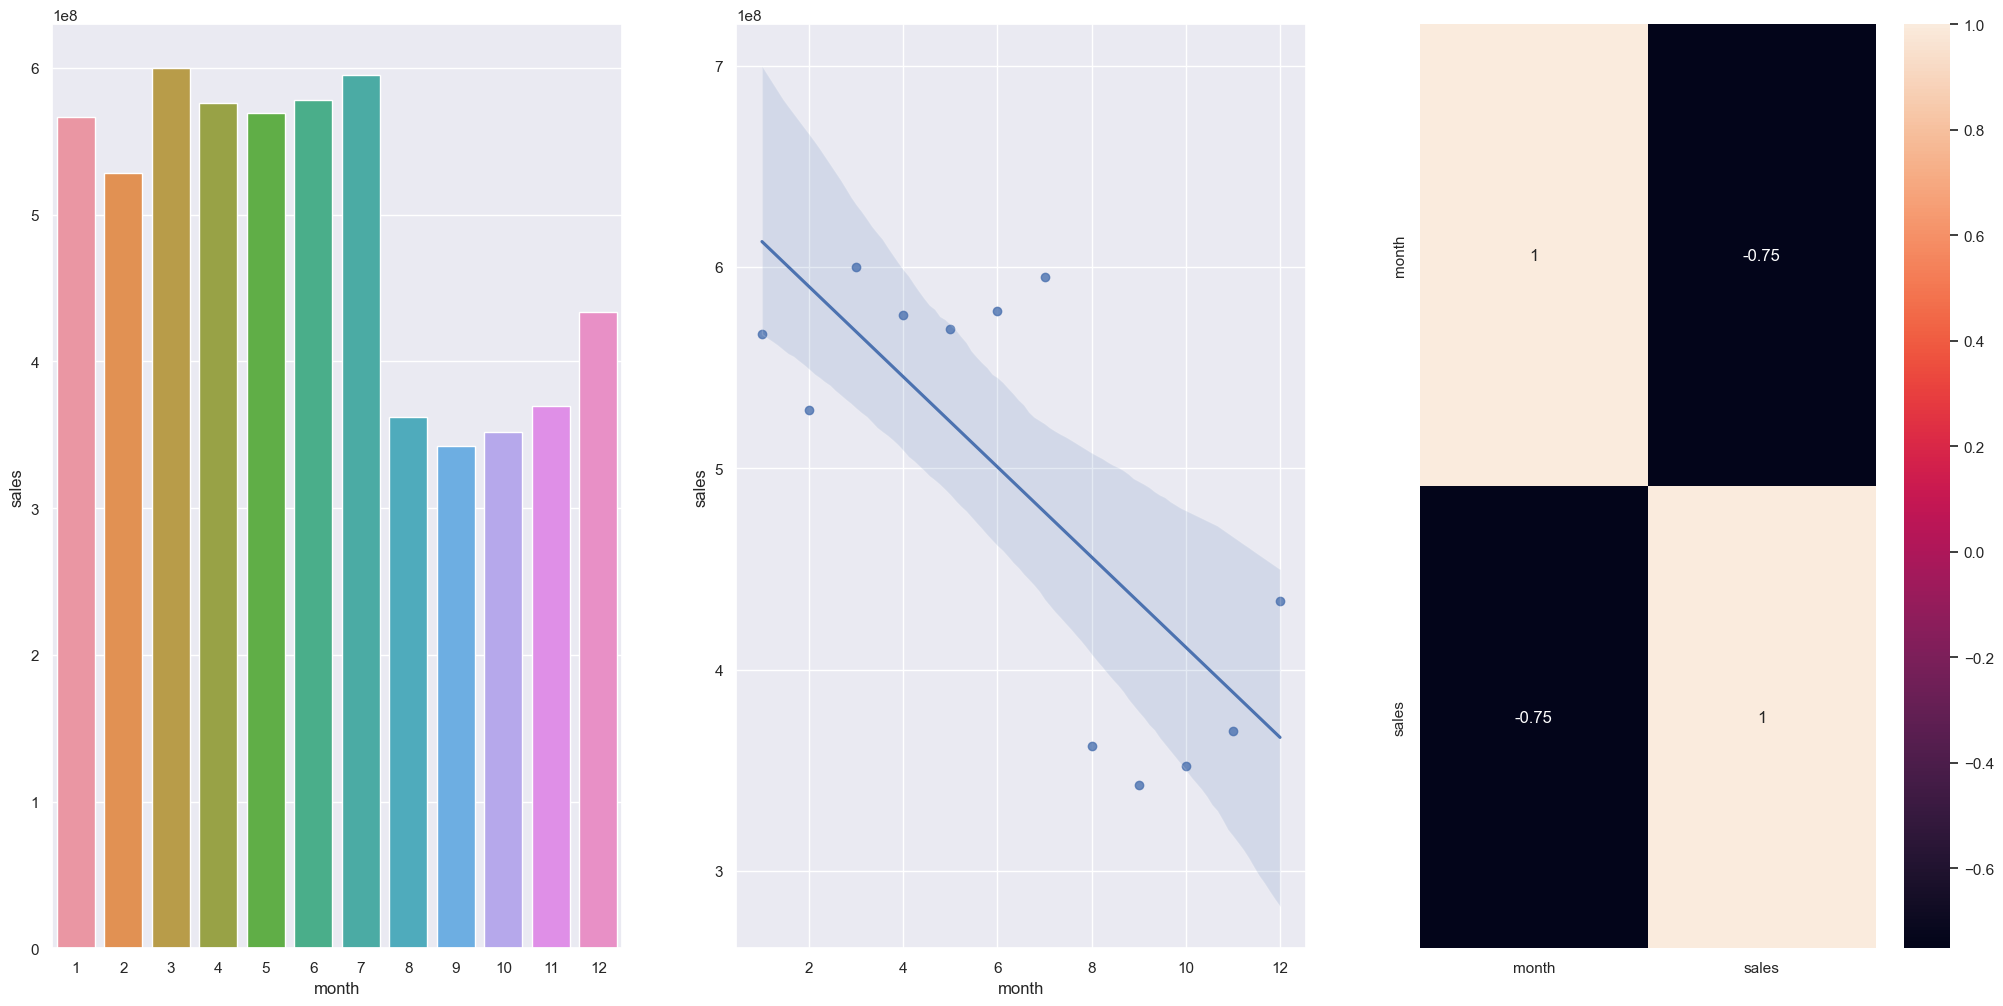

In [55]:
aux1=df4[['month','sales']].groupby('month').sum().reset_index()

pt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

pt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

pt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**


- apesar das maiorias das pessoas receberem durante o primeiro dez dias dos meses estamos comprando com o restate que o dobro de tempo , vemos então que o numero de vendas é bem menos que comparada com o restante do mês

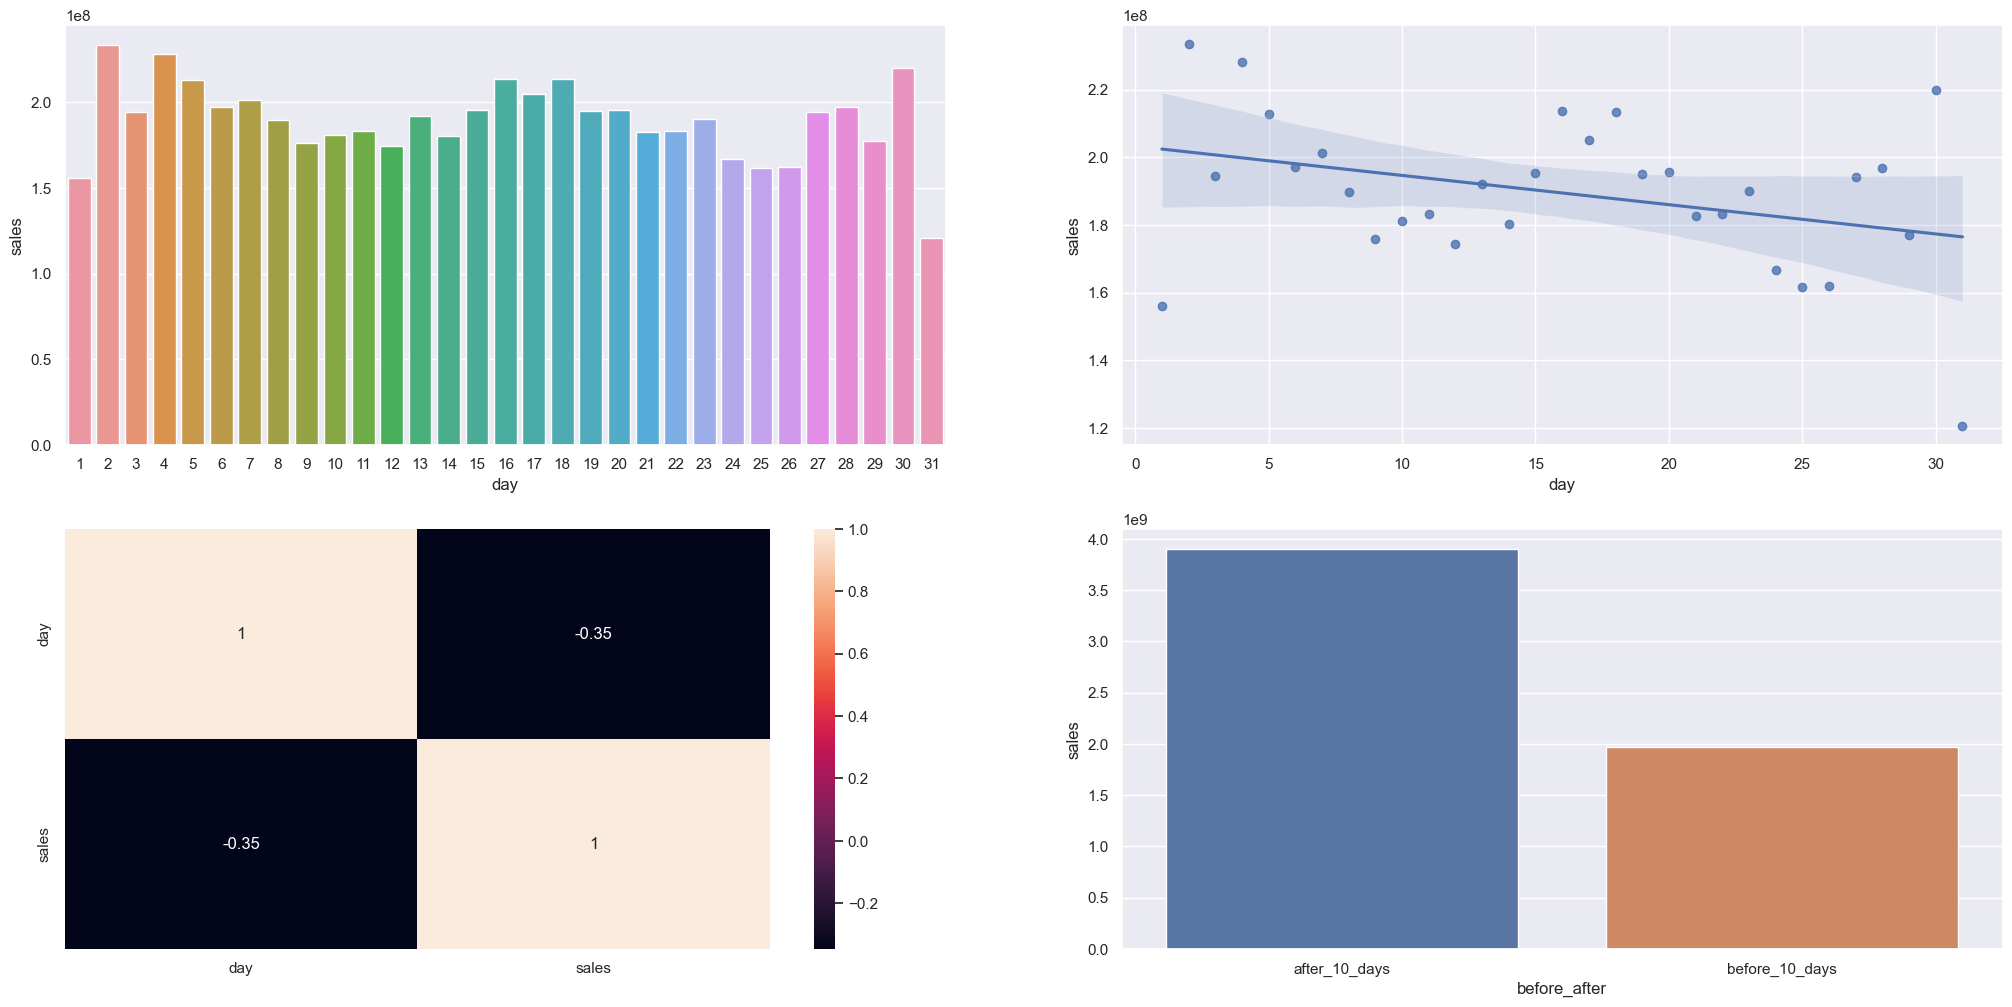

In [56]:
aux1=df4[['day','sales']].groupby('day').sum().reset_index()

pt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

pt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

pt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2=aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

pt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales',data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**



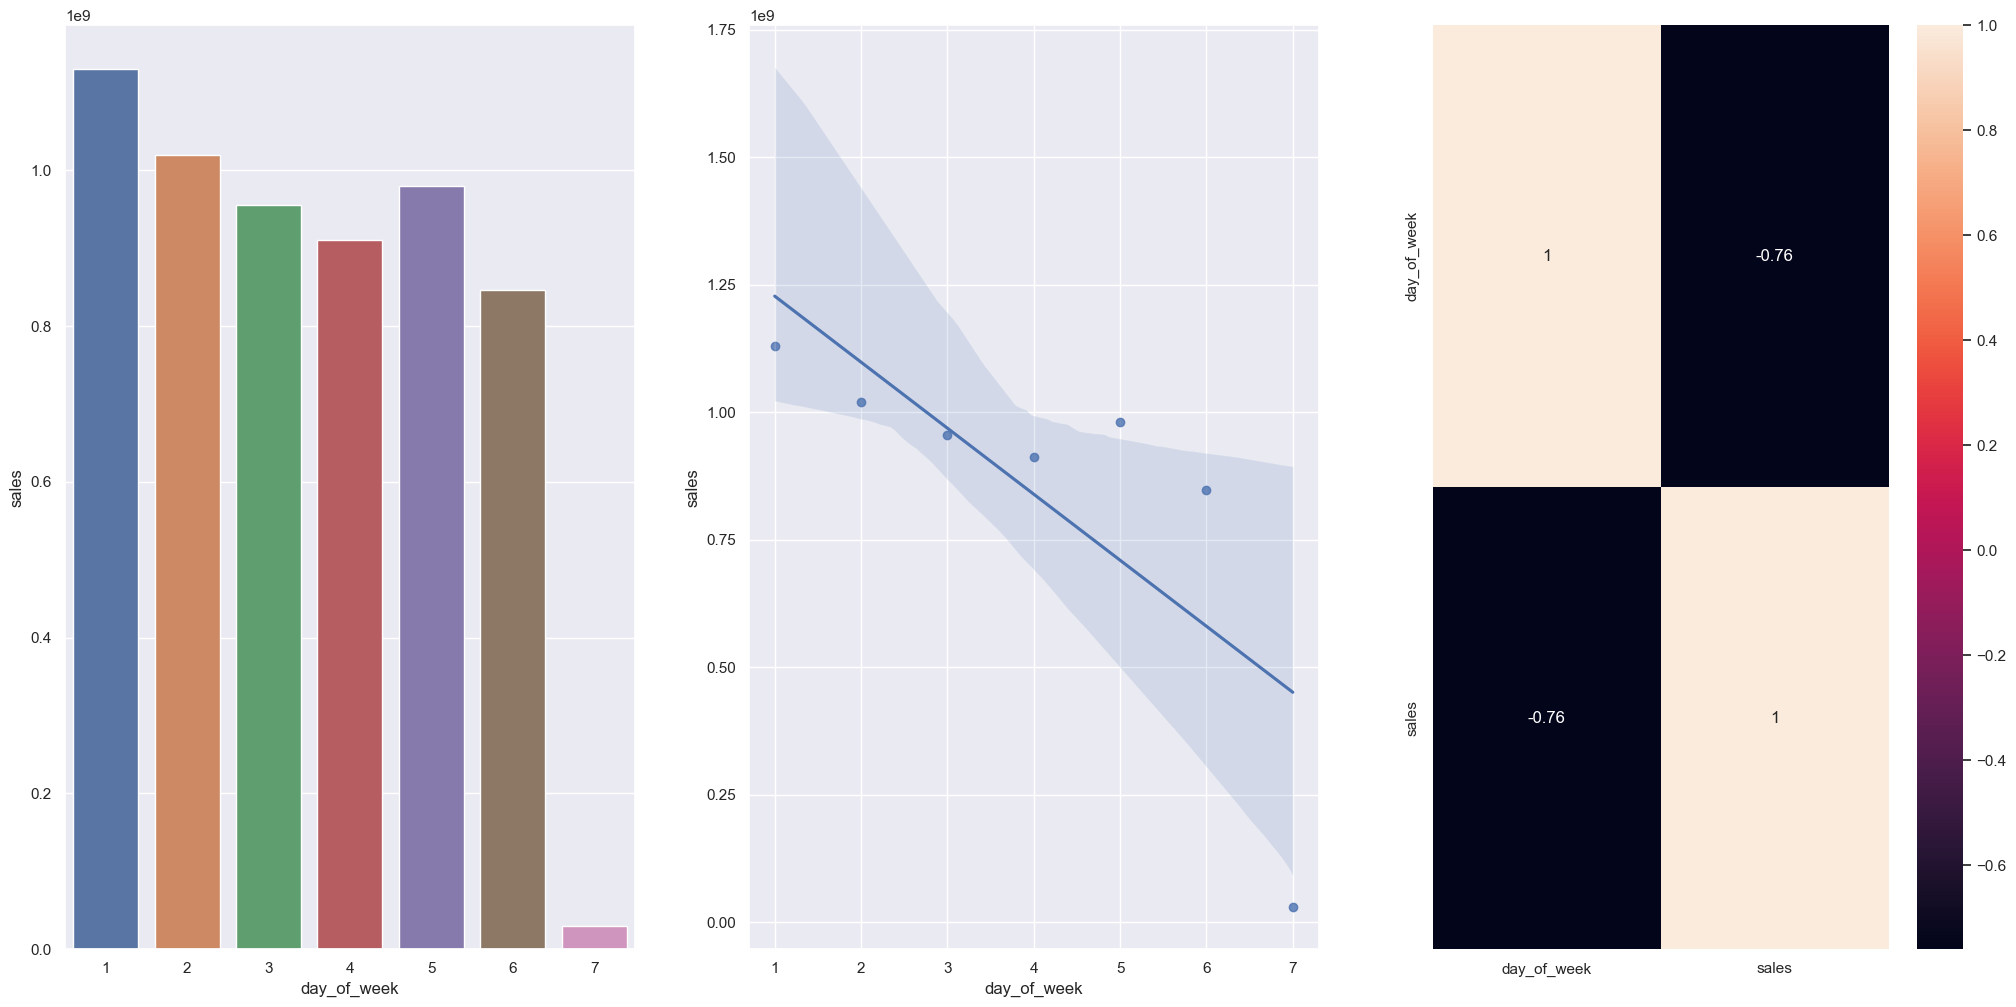

In [57]:
aux1=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

pt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

pt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

pt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante feriados escolares.
**VERDADEIRA**

- é uma hipotese verdadeira , mas resaoltando que nos meses de julho e agosto não temos essa afirmação as loja vendem mais , 

<Axes: xlabel='month', ylabel='sales'>

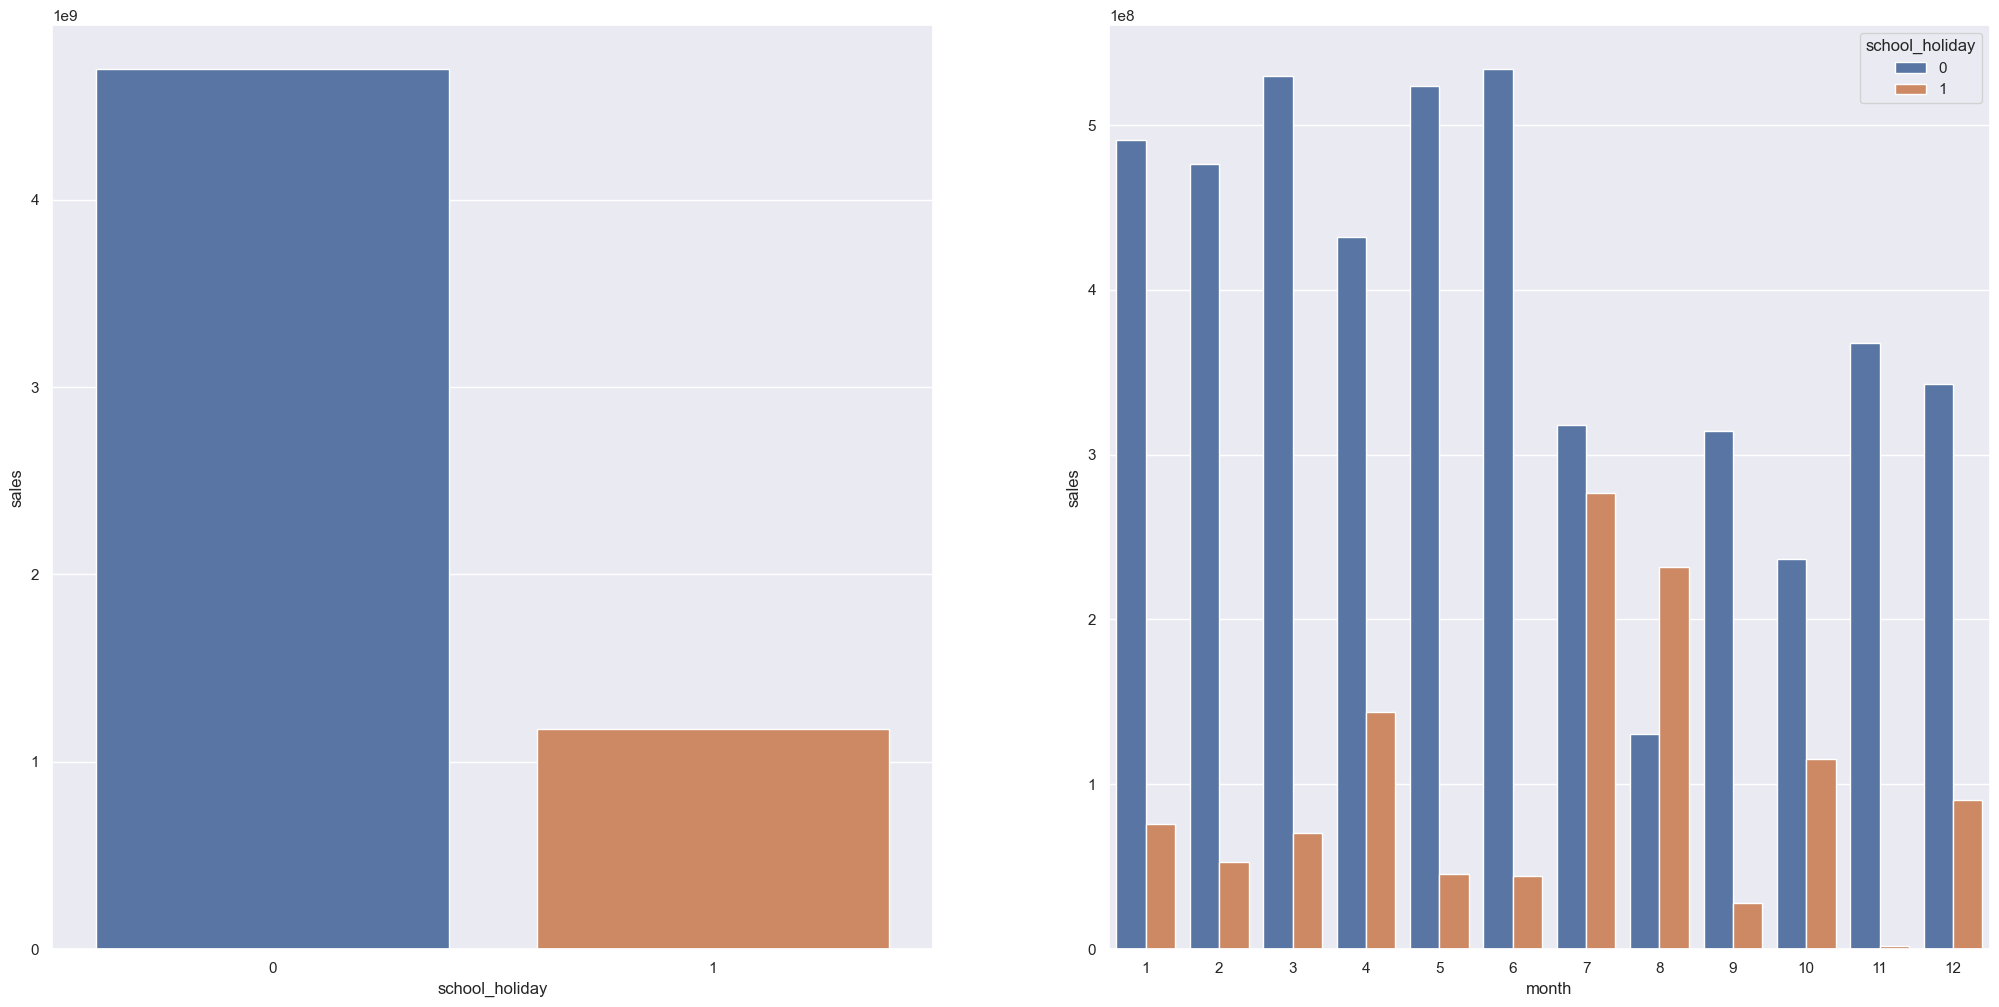

In [58]:
aux1=df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

pt.subplot(1,2,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

pt.subplot(1,2,2)
aux2= df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2)



### 4.2.1 Resumo das Hipoteses

In [59]:
tab=[['Hipotese', 'Conclusão','Relevancia'],
    ['H1','Falsa','Baixa'],
    ['H2','Falsa','Media'],
    ['H3','Falsa','Media'],
    ['H4','Falsa','Baixa'],
    ['H5','--','--'],
    ['H6','Falsa','Baixa'],
    ['H7','Falsa','Media'],
    ['H8','Falsa','Alta'],
    ['H9','Falsa','Alta'],
    ['H10','Verdadeira','Alta'],
    ['H11','Verdadeira','Alta'],
    ['H12','Verdadeira','Baixa'],
    ]
print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          --           --
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Análise Multivariada

- Teoria da navalha de Occam:

Se você tiver vario modelos para escolher tem cque escolher o que tiver menos complexidade, porque ele generaliza o aprendizado de forma melhor.

-**Quando que um  se torna mais complexo ?** 

Complexidade a gente pode entender pela quantidade de numero de colunas , podemos selecionar(ou retirar) as colunas que são extremamente importante para o aprendizado do algoritimo.

Quanto de informação cada coluna carrega

Olhar a correlação das  variáveis 
 


### 4.3.1 Numerical Attributes

<Axes: >

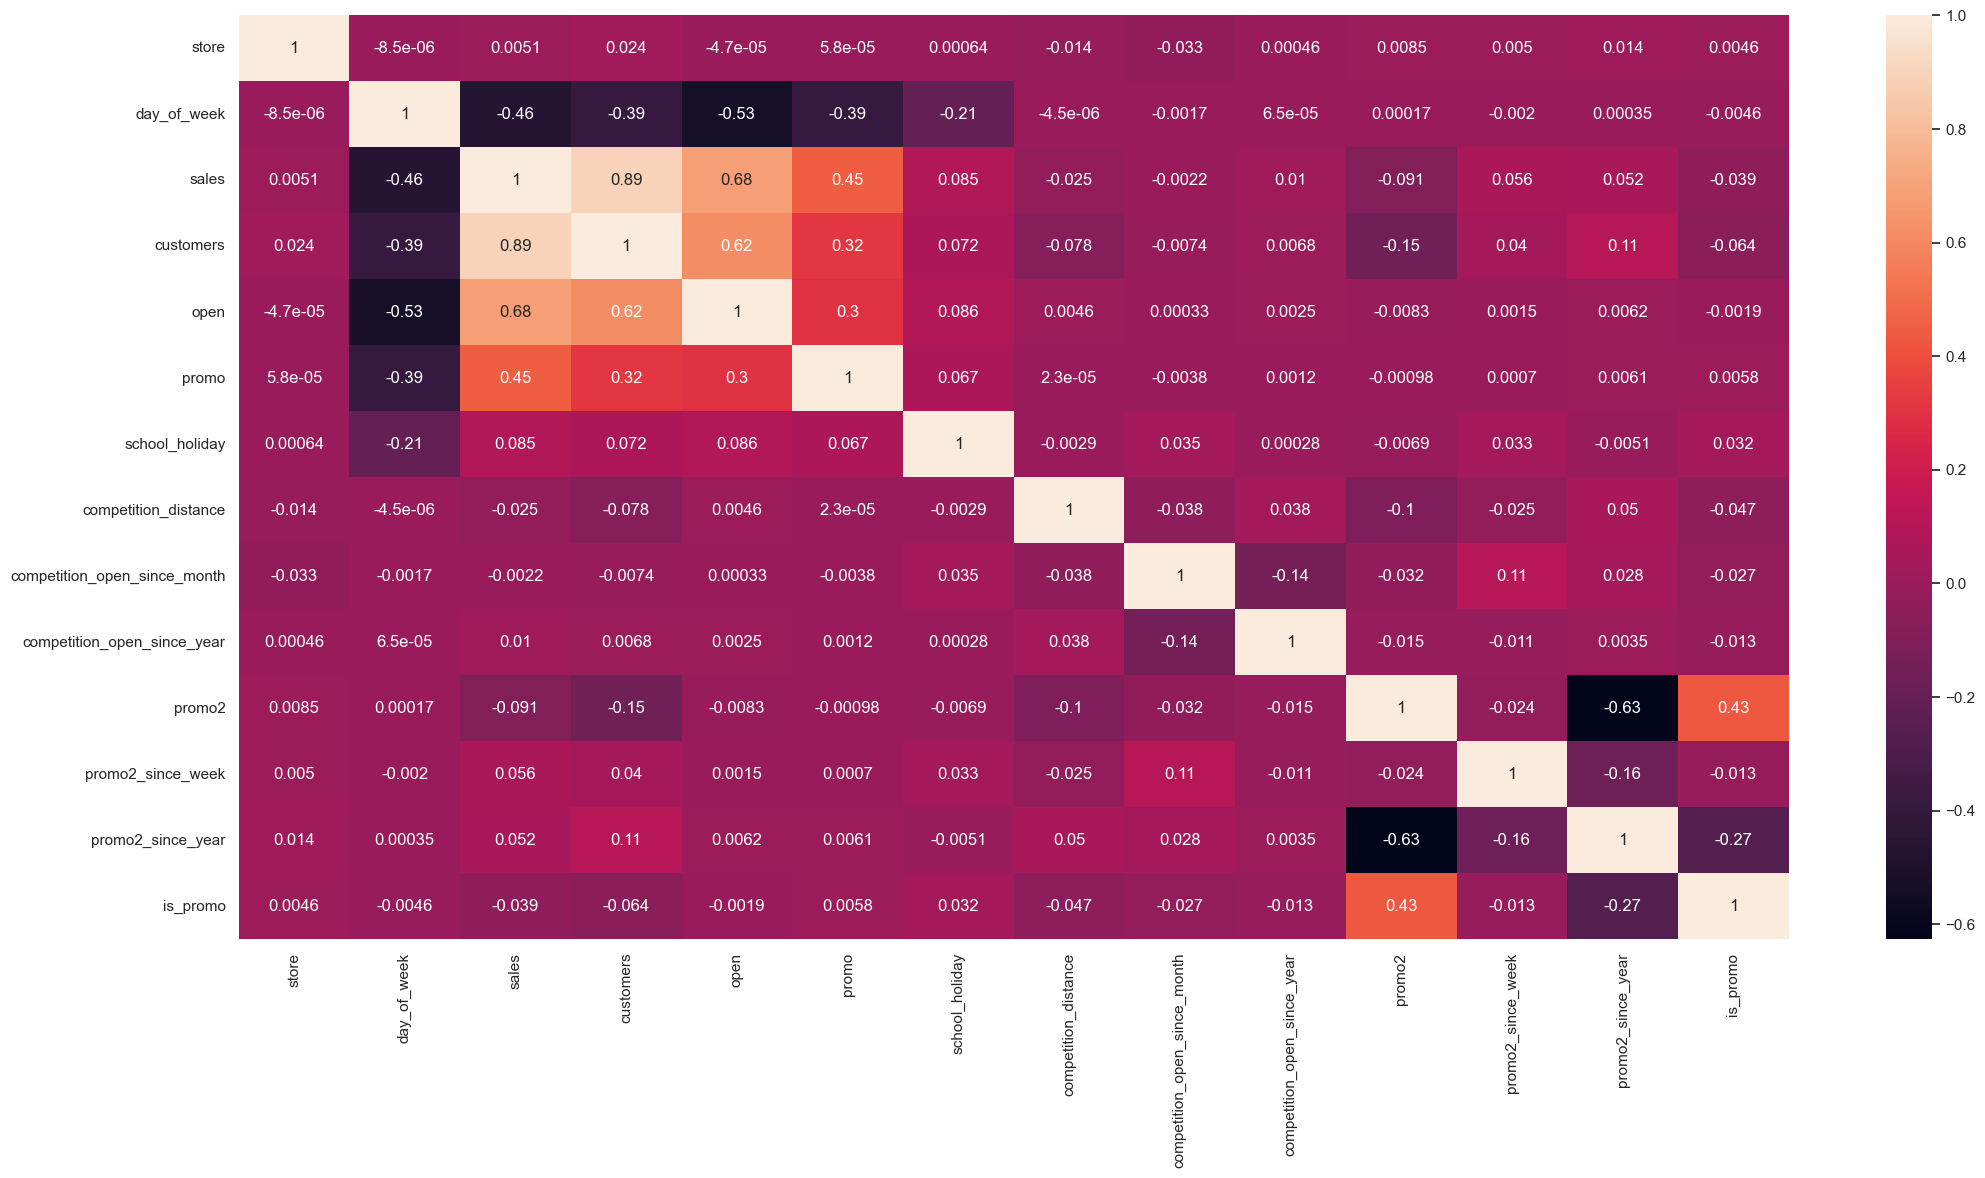

In [60]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap ( correlation, annot= True)


### 4.3.2 Categorical Attributes

In [61]:
a= df4.select_dtypes( include = 'object' )


In [62]:
a.head(3)

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30


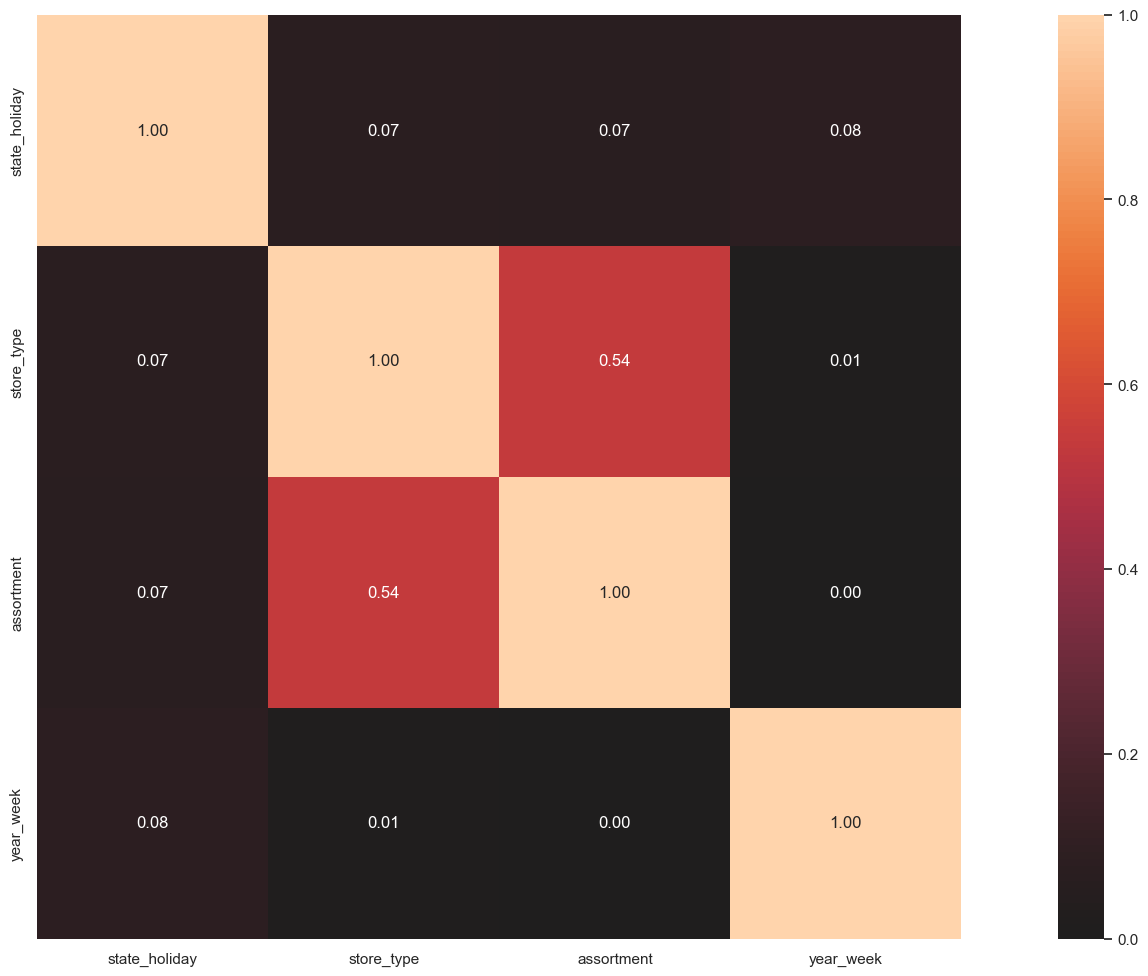

{'corr':                state_holiday  store_type  assortment  year_week
 state_holiday       1.000000    0.071040    0.067519   0.082499
 store_type          0.071040    1.000000    0.538454   0.008492
 assortment          0.067519    0.538454    1.000000   0.003511
 year_week           0.082499    0.008492    0.003511   1.000000,
 'ax': <Axes: >}

In [63]:
associations(a)

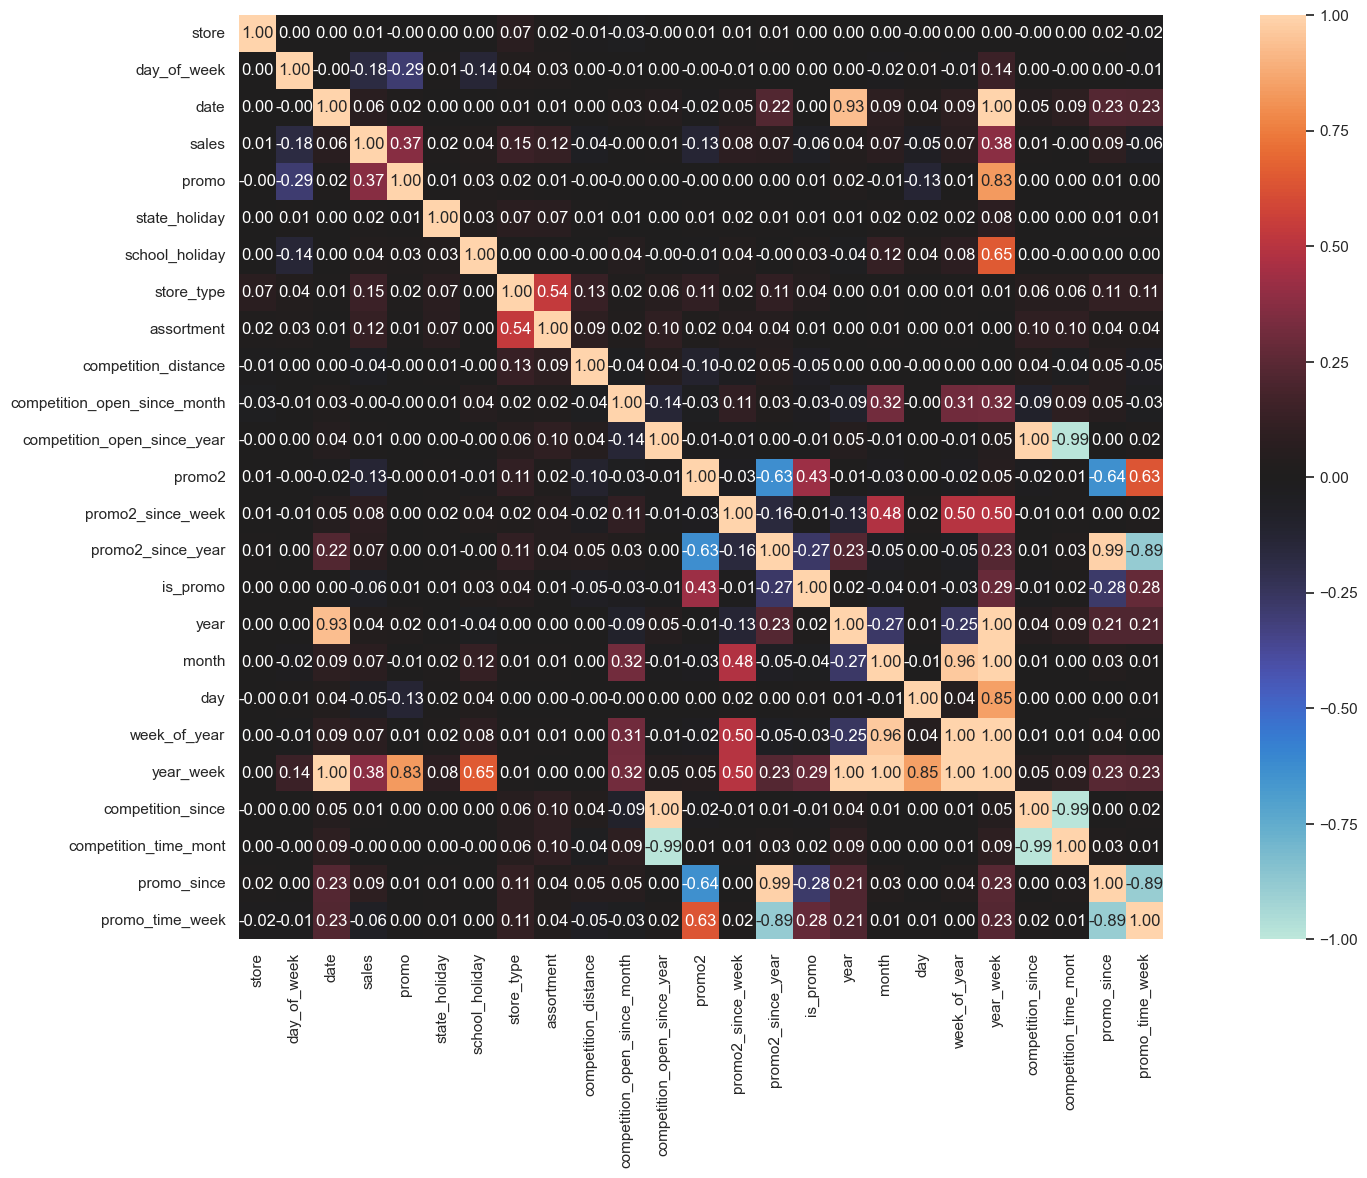

In [64]:
#Correlação de variaveis categoricas e númericas 
associations(df4);

# 5.0. PASSO 5 - DATA PREPARATION

- O aprendizado da maioria dos modelos de Machine Learning é facilitado transformando todos os dados em valores númericos e de mesmo peso, ou seja eu não posso ter valores muitos altos se não o meu algoritimo vai dar maior importancia , tenho que ter o balanciamento dos dados.

- O nome que damos a essa tecnica é de : *encoding* sem perder o conteúdo de informação  

In [65]:
df5=df4.copy()

## 5.1. Normalização

- Olhando o passo da analise exploratoria de dados 4.0 , observamos  na analise 4.1.2 Numerical Variable que não possuimos nenhuma varial com normalização .

## 5.2 . Reascaling

- Min-Max Scaler - O problema dele é com outline pq a forma eu uso o valores max - min e ai eu vou ter valores muito proximo de zero na nova escala;

- Robust Scarler - em vez de subtrari os valores max e min eu vou usar o 1º quartil e 3º Quartil;



In [66]:
#Selecionando todas as variáveis númericas
df5.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

In [67]:
a = df5.select_dtypes(include=['int64','float64','UInt32'])

In [68]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_mont,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


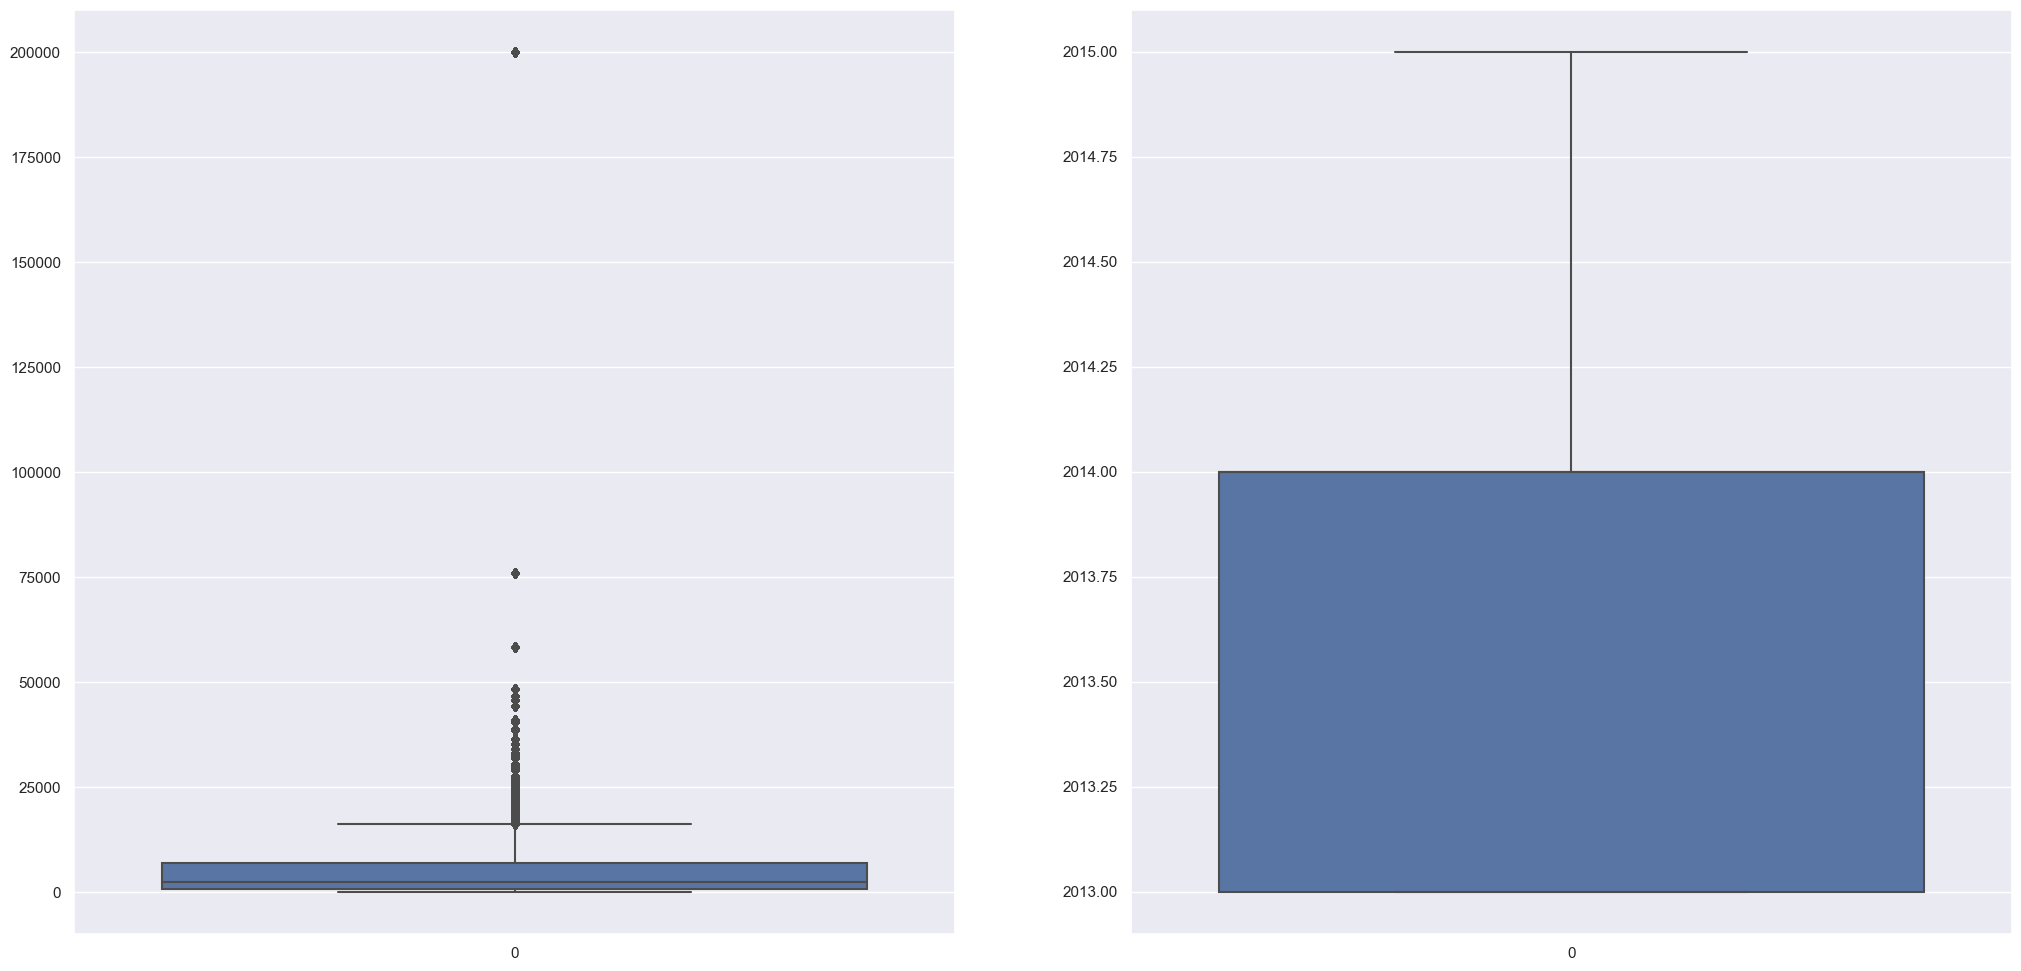

In [69]:
#SABER OS OUTLINER PARA USAR O METODO DE MAX-MIN OU SCALER
pt.subplot(1,2,1)
sns.boxplot(df5['competition_distance']);
pt.subplot(1,2,2)
sns.boxplot(df5['year']);



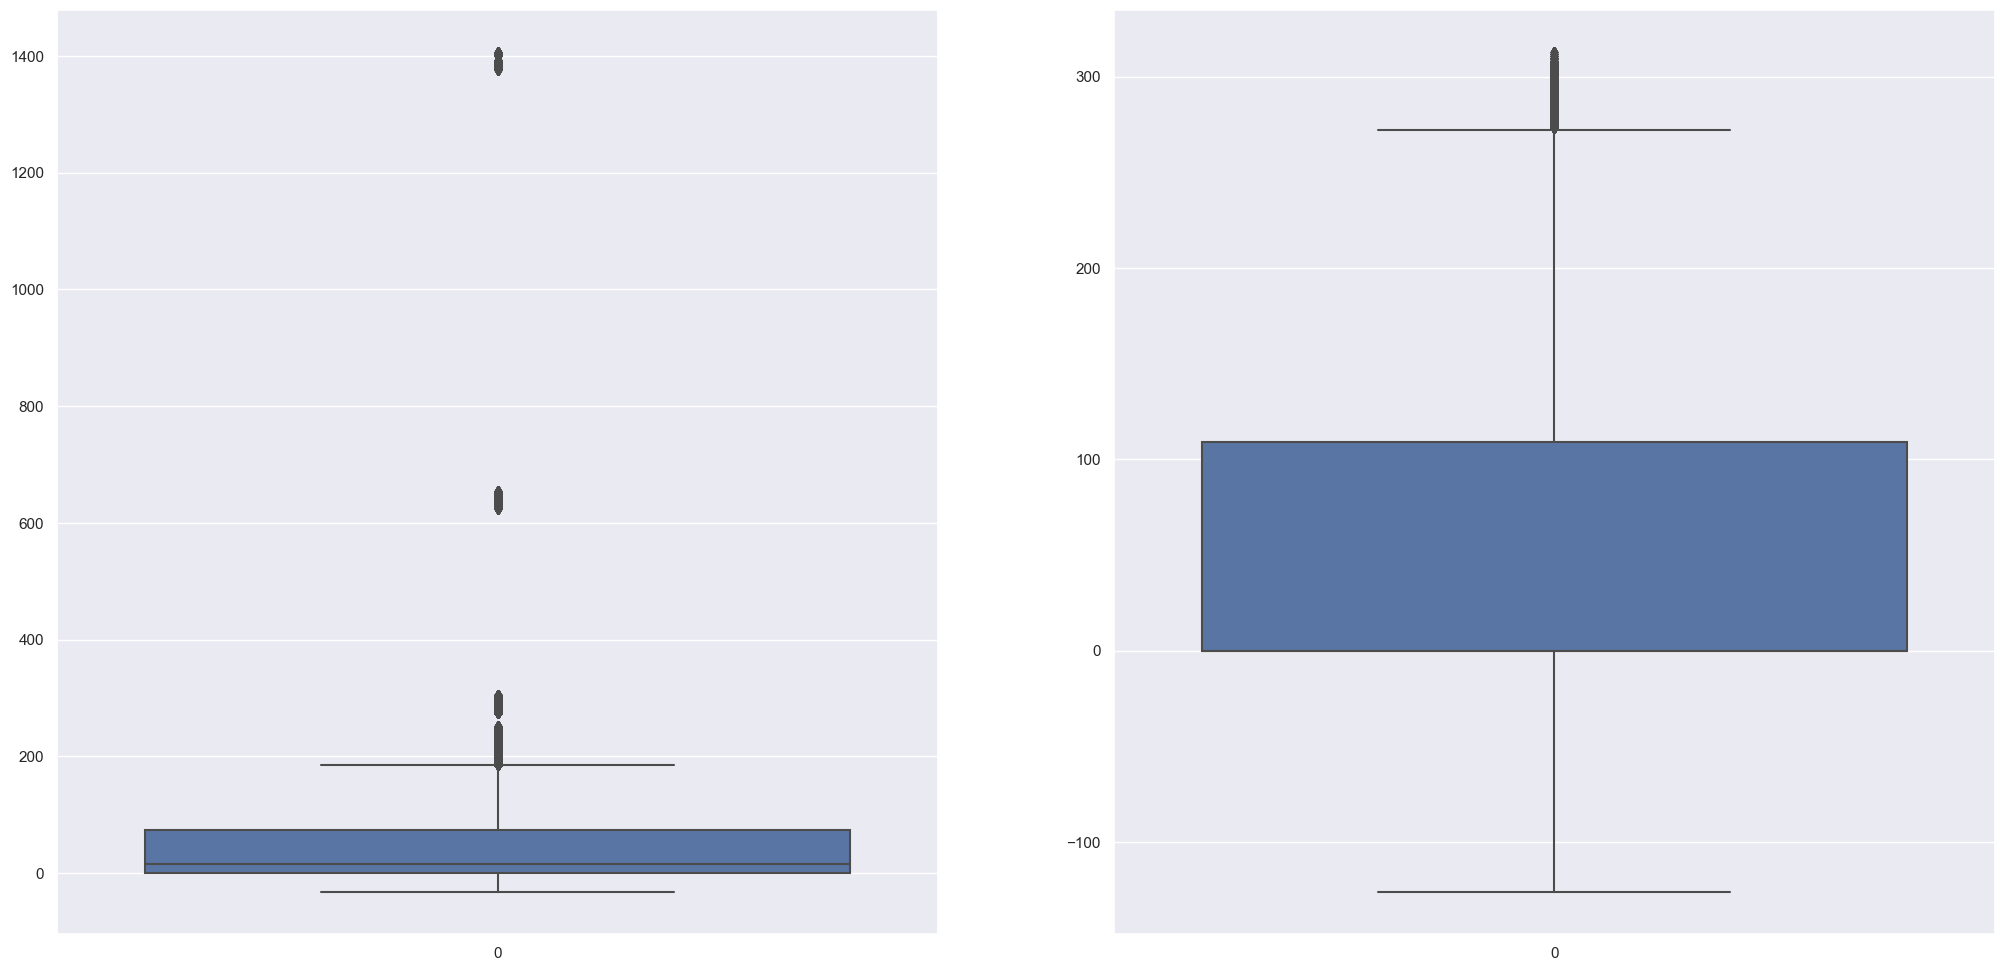

In [70]:
#SABER OS OUTLINER PARA USAR O METODO DE MAX-MIN OU SCALER
pt.subplot(1,2,1)
sns.boxplot(df5['competition_time_mont']);
pt.subplot(1,2,2)
sns.boxplot(df5['promo_time_week']);

In [71]:

rs= RobustScaler()
mms= MinMaxScaler()
#competition_distance (Robust Scarler )
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/competition_distance_scaler.pkl','wb') )
#competition_time_mont(Robust Scarler )

df5['competition_time_mont'] = rs.fit_transform( df5[['competition_time_mont']].values )
pickle.dump(rs, open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/competition_time_mont_scaler.pkl','wb') )


#promo_time_week(Min-Max)
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(rs, open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/promo_time_week_scaler.pkl','wb') )

#year (Min-Max)
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/year_scaler.pkl','wb') )



In [72]:
pwd

'/home/leticia/Documentos/comunidade_ds/ds_producao/Notebook'

## 5.3 Tipos de Encoding


- **1.0 One Hot Encoding**

Cria novas colunas com 0 e 1 ;

indicado para variaveis que tem no max 3 tipos de categoria;

Vantagens==> muito simples de se aplicar ;

Desvantagens ==> Cria muitas novas colunas;

ex: feriados


- **2.0 Label Encoding**

Troco os nomes das variaveis categoricas por numeros inteiros aleátorios;

indicado para variaveis que não tem relação 

ex: nome de cor



- **3.0 Ordinal Encoding**

Usado por variaveis categorica que carrega um tipo de relação ;

ex: tipos de temperatura existe umas mais quentes e outas mais frias e ele pode classificar isso em ordem; maior, menor , meldio ,alto  


- **4.0 Target Encoding**

Quando eu tenho muitos tipos de variáveis categoricas ;
ele subistitui a variável categorica por um numero que é a media da minha variavel resposta .

ex: cores, estados , paises,

- **5.0 Frequency Encoding**

Ele faz a contagem de quantas vezes minha variavel categorica aparece e substittui pela o numero numerico, substitui para porcentagem .

Ex: marcas de carros 

- **6.0 Embedding Encoding**

redes Neorais 

NLP






## 5.4 Transformação

### 5.4.1 Encoding

In [73]:
#state_holiday- Onde Hot Encoding
df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

#store_type - Label Encoding- não tem tipo de relação 

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le,open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/store_type_scaler.pkl','wb'))



#assortment - Ordinal Encoding- tem um tipo de relação
# Fazer o dicionario para colocar a importancia de cada um.
assortment_dict={'basic': 1,'extra': 2,'extended': 3}
df5['assortment']=df5['assortment'].map(assortment_dict)




### 5.4.2. Response variable Transformation

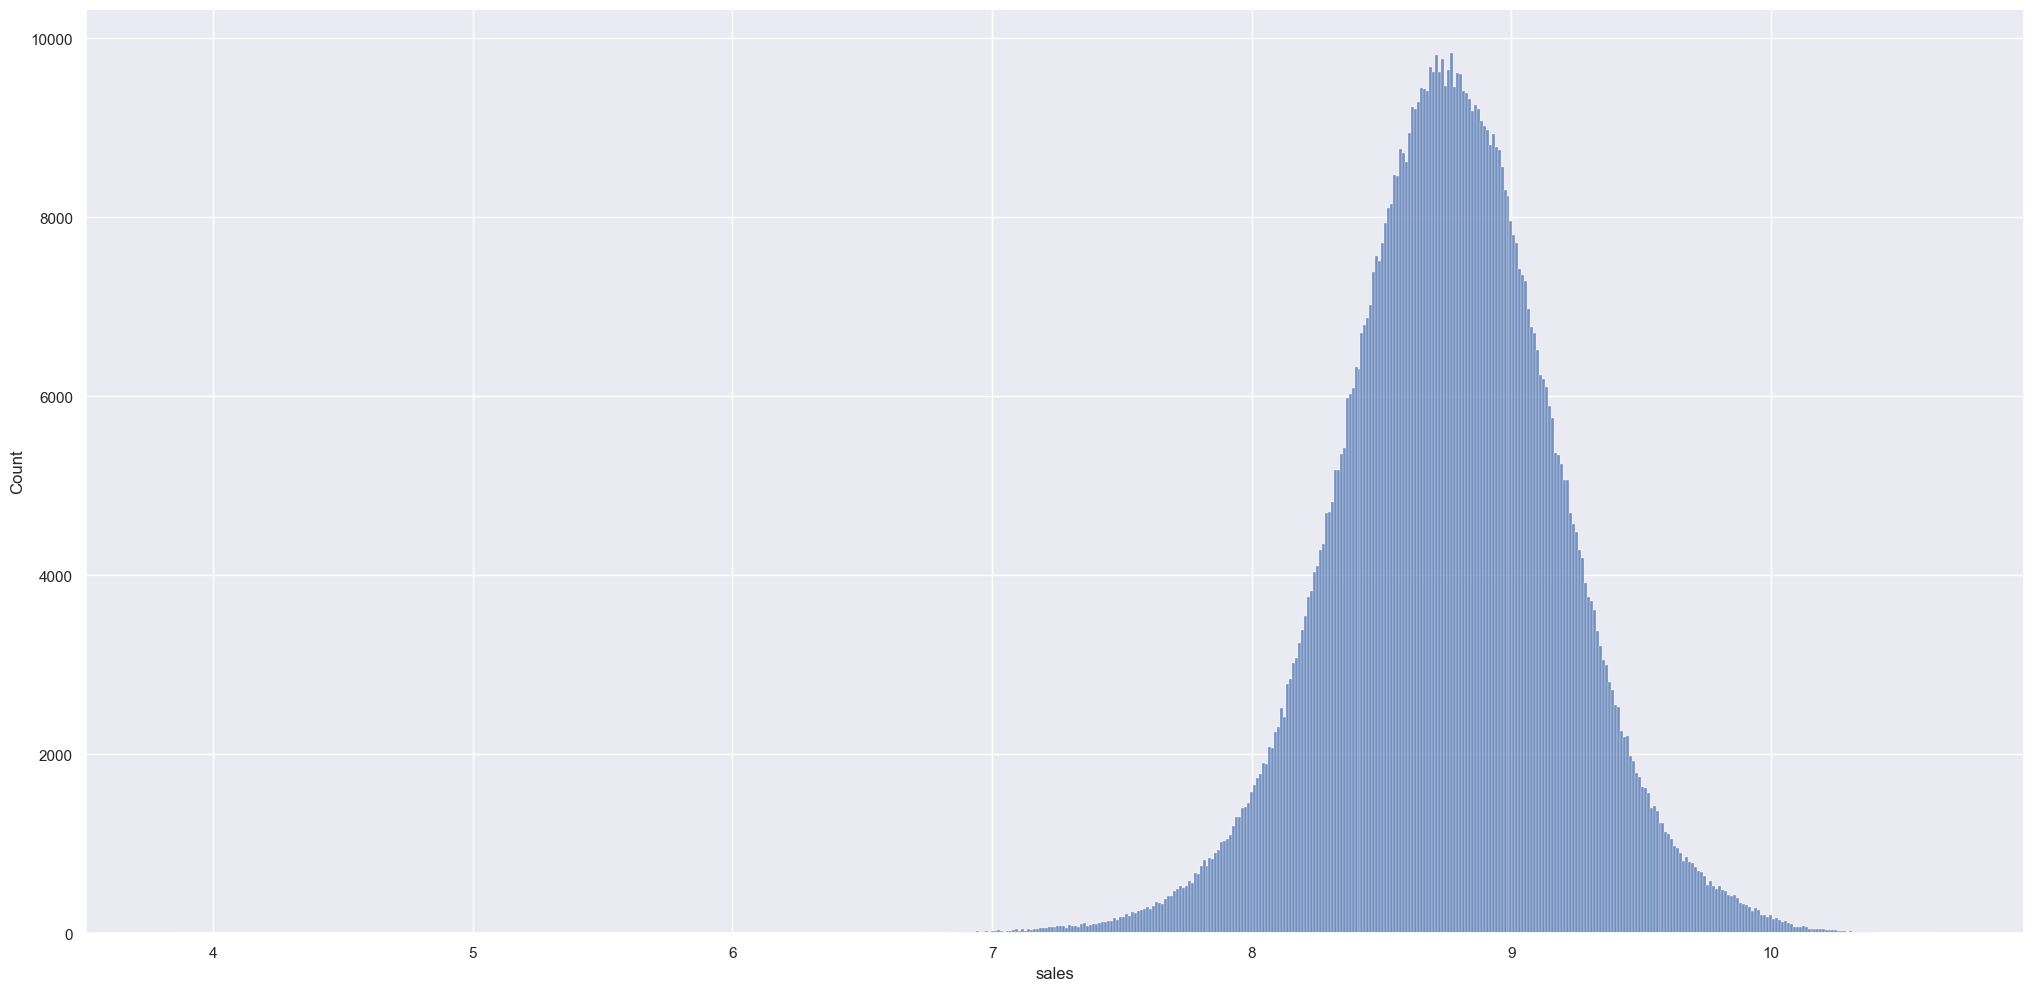

In [74]:
#transformando a variavel resposta para a normal 
df5['sales'] = np.log1p(df5['sales'])
sns.histplot(df5['sales']);

 ### 5.4.2- Transformação  Ciclica

In [75]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2.* np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2.* np.pi/7 ) ) )

#month 
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2.* np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2.* np.pi/12 ) ) )  

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2.* np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2.* np.pi/30) ) )

#week_of_year 
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/53 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/53 ) ) )


In [76]:
df5.shape

(844338, 36)

In [77]:
df1.shape

(1017209, 20)

# 6.0. PASS0 6 - SELEÇÃO DE VARIAVEL 

- A explicação mais simples sobre o fenômeno observado, deveria prevalecer sobre explicações mais complexa.

- modelos mais simples generaliza melhor  fenomeno estudado 

- Aprender selecionar as variáveis 

## 6.1.0 Removendo variáveis Colineares

- São variáves que repesenta a mesma coisa, a mesma parte do fenômeno estudado.

In [78]:
df6=df5.copy()

In [79]:
df6.head(4)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_mont,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.508531,-0.861044
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.508531,-0.861044
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.508531,-0.861044
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.508531,-0.861044


In [80]:
df6.shape

(844338, 36)

## 6.2.0  Fazendo a divisão do dataset entre Treino e teste

In [81]:
# Apagar colunas na qual eu fiz as transformações 
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6= df6.drop( cols_drop, axis=1 )

In [82]:
df6.shape

(844338, 29)

In [83]:
#separando o datafreme por treino e teste 
# como meu algoritimo é para prever as ultimas seis semanas de cada loja optei por separa os dados treino para as ultimas 6 semanas .
#descobrindo a ultima data que tem na minha base de dados
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days =6*7)

Timestamp('2015-06-19 00:00:00')

In [84]:
#separando o dataframe 

#treino dataset
x_train= df6[df6['date']<'2015-06-19' ]
y_train = x_train['sales']

#teste
x_test= df6[df6['date']>= '2015-06-19' ]
y_test = x_test['sales']

print( 'Training Min Date:{}'.format(x_train['date'].min()))
print( 'Training Max Date:{}'.format(x_train['date'].max()))

print( 'Training Min Date:{}'.format(x_test['date'].min()))
print( 'Training Max Date:{}'.format(x_test['date'].max()))



Training Min Date:2013-01-01 00:00:00
Training Max Date:2015-06-18 00:00:00
Training Min Date:2015-06-19 00:00:00
Training Max Date:2015-07-31 00:00:00


In [85]:
x_train.shape


(802942, 29)

In [86]:
y_train.shape

(802942,)

In [87]:
x_test.shape

(41396, 29)

In [88]:
y_test.shape

(41396,)

## 6.3.0 Seleção de Feature pelo algoritimo BORUTA

In [89]:
##training and test dataset for boruta
#x_train_n= x_train.drop(['date','sales'],axis=1 ).values #retirando minha variavel resposta
#y_train_n= y_train.values.ravel()

#define RandomForestRegressor 
#rf = RandomForestRegressor( n_jobs=-1 )

#define Boruta 
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state=42 ).fit(x_train_n, y_train_n)

### 6.3.1 - Seleção das melhores colunas pelo boruta 

In [90]:
#cols_selected = boruta.support_.tolist()
##melhores colunas 
#x_train_fs = x_train.drop(['date','sales'],axis=1 )
##cols_selected_boruta = x_train_fs.iloc[:, cols_selected ].columns.to_list()

#colunas que NÂO foram selecionada pelo boruta
#cols_not_select_boruta = list(np.setdiff1d(x_train_fs.columns ,cols_selected_boruta ) )

In [91]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_mont',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_cos']

#columns para dd 
feat_to_add = ['date' ,'sales']

#final features
cols_selected_boruta_full= cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


In [92]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_mont',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [93]:
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_mont,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.891892,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.17689,-0.984231
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,1.027027,0.908884,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.17689,-0.984231
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,1.189189,0.788155,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.17689,-0.984231
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.729730,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.17689,-0.984231
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,-0.189189,0.287016,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.17689,-0.984231


# 7.0 PASSO 7- MODELO DE MACHINE LEARNING

In [94]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

# seção cross validation
x_training= x_train[cols_selected_boruta_full]

In [95]:
x_training.dtypes

store                                    int64
promo                                    int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
competition_time_mont                  float64
promo_time_week                        float64
day_of_week_sin                        float64
day_of_week_cos                        float64
month_cos                              float64
day_sin                                float64
day_cos                                float64
week_of_year_cos                       float64
date                            datetime64[ns]
sales                                  float64
dtype: object

## 7.1- Averange Model 

- Modelo que iera calcular a média serve como base para os demais modelos.

In [96]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

##prediction
aux2 = aux1[['store', 'sales']].groupby ('store').mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge ( aux1 , aux2, how ='left' ,on = 'store' )
yhat_baseline = aux1['predictions']

##performace
baseline_result =ml_error('Average Model', np.expm1(y_test),  np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


In [97]:
x_train.dtypes


store                                    int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
competition_time_mont                  float64
promo_time_week                        float64
state_holiday_christmas                  uint8
state_holiday_easter_holiday             uint8
state_holiday_public_holiday             uint8
state_holiday_regular_day                uint8
day_of_week_s

## 7.2- Linear Regression Model 
- Modelo tem o comportamento linear é um dos mais simples para ver se o problema de negocio tem esse comportamento

In [98]:
#model 
lr = LinearRegression().fit(X_train, y_train)

#prediction
yhat_lr = lr.predict( X_test )

#performece 
lr_result= ml_error('Linear Regression',np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.439256,0.294246,2669.580308


### 7.2.1 Linear Regresssion Model -Cross Validation

In [99]:

lr_result_cv = cross_validation( x_training, 5, 'Linear Regression ',lr,verbose=False)
lr_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.2 +/- 297.26,0.3 +/- 0.02,2956.13 +/- 466.7


## 7.3.Linear Regression Regularized Model Lasso

In [100]:
# model Lasso
lrr = Lasso(alpha=0.00001).fit( X_train, y_train )

# prediction
yhat_lrr = lr.predict( X_test )
# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1(yhat_lrr ) )
lrr_result 


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1867.983849,0.290883,2680.092655


### 7.31-Linear Regression Regularized Model Lasso- Cross Validation



In [101]:
 lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Lasso ',lrr,verbose=False)



- Comparando os modelos de regressão,lasso e o de média notamos que meus dados tem um comportamento NÃO linear  ao observar o RMSE que significa a quantidade de error que meu agoritmo calculou  

## 7.4-RandomForestRegressor

In [102]:
#model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

#prediction
yhat_rf = rf.predict( X_test )

#performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,729.346865,0.108266,1073.958566


### 7.4.1 Raandom Forest Regressor - Cross Validation

In [103]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regresso ',rf,verbose=False)
rf_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regresso,852.18 +/- 237.25,0.12 +/- 0.03,1274.7 +/- 347.25


## 7.5 XGBRegressor

In [104]:

xgb = XGBRegressor().fit( X_train, y_train)  

# prediction
yhat_xgb = xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,898.111733,0.133939,1296.107232


### 7.5 XGBRegressor - Cross validation

In [105]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor ',xgb,verbose=False)

xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1079.31 +/- 177.34,0.15 +/- 0.02,1542.68 +/- 245.84


## 7.6- Comparação da performace de todos os modelos 

In [106]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,729.346865,0.108266,1073.958566
0,XGBoost Regressor,898.111733,0.133939,1296.107232
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.439256,0.294246,2669.580308
0,Linear Regression Lasso,1867.983849,0.290883,2680.092655


### 7.6.1 Real performace - cross validation

In [107]:
modelling_result_csv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_csv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.2 +/- 297.26,0.3 +/- 0.02,2956.13 +/- 466.7
0,Linear Regression Lasso,2079.3 +/- 297.73,0.3 +/- 0.02,2956.7 +/- 467.13
0,Random Forest Regresso,852.18 +/- 237.25,0.12 +/- 0.03,1274.7 +/- 347.25
0,XGBoost Regressor,1079.31 +/- 177.34,0.15 +/- 0.02,1542.68 +/- 245.84


# 8.0. PASSO 8 -  HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [108]:
warnings.filterwarnings('ignore')

In [109]:
#param = {
#         'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]
#         }

#MAX_EVAL = 10



In [110]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
#    #choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
    
#    #model
#    xgb = XGBRegressor( objective='reg:squarederror',
#                        n_estimators=hp['n_estimators'],
#                        eta=hp['eta'],
#                        max_depth=hp['max_depth'],
#                        subsample=hp['subsample'],
#                        colsample_bytree=hp['colsample_bytree'],
#                        min_child_weight=hp['min_child_weight'] )
    
#    #performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )

#final_result
#1{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
#2{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
#3{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
#4{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

#5{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
#6{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
#7{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
#8{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
#9{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
#10{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}

## 8.2 Final model 

In [111]:
 param_tuned = {
                'n_estimators':3000,
                'eta':0.03,
                'max_depth':9 ,
                'subsample':0.5,
                'colsample_bytree': 0.7,
                'min_child_weight': 15
                }



           



In [112]:
# # model
model_xgb_tuned = XGBRegressor( objective='reg:squarederror',
                               n_estimators=param_tuned['n_estimators'],
                               eta=param_tuned['eta'],
                               max_depth=param_tuned['max_depth'],
                               subsample=param_tuned['subsample'],
                               colsample_bytree=param_tuned['colsample_bytree'],
                               min_child_weight=param_tuned['min_child_weight'])

# #fit
model_xgb_tuned.fit( X_train, y_train)
## prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

## performance
xgb_result_tuned = round( ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned )),2 )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,641.0,0.09,929.51


In [113]:
model_xgb_tuned

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=15, missing=nan,
             monotone_constraints=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [114]:
#xgb_result_tuned
pickle.load(open('/home/leticia/Documentos/comunidade_ds/ds_producao/Notebook/model_rossmann.pkl', 'rb'))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=15, missing=nan,
             monotone_constraints=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [115]:
 pickle.dump( model_xgb_tuned,open('/home/leticia/Documentos/comunidade_ds/ds_producao/Notebook/model/model_rossmann.pkl', 'wb'))

In [116]:
#OBS !
#para saber se meu error é pequeno ou grande tenho que ver meu range(maior valor - menor valor) a variavel resposta 
np.expm1(y_test).min()

569.0000000000002

In [117]:
 np.expm1(y_test).max()

41550.99999999998

In [118]:
np.expm1(y_test).max() - np.expm1(y_test).min()
#meu range de 40981 é muito alto então o valor do meu erro não é tão significante 

40981.99999999998

# 9.0. PASSO - 09 TRADUÇÃO E INTERPRETAÇÃO DO ERROR 

In [119]:
df9 = x_test[cols_selected_boruta_full]

#rescale 
df9['sales']=np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance 

In [120]:
#sum of predictions

df91=df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1=df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error( x['sales'], x ['predictions'] ) ).reset_index().rename(columns={0:'MAE'})
df9_aux2=df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error( x['sales'], x ['predictions'] ) ).reset_index().rename(columns={0:'MAPE'})

#Merge de MAE E MAPE
df9_aux3=pd.merge(df9_aux1, df9_aux2, how= 'inner',on='store')
df92=pd.merge(df91,df9_aux3, how='inner', on='store')

#Cenários 
df92['worst_scenario'] = df92['predictions'] -  df92['MAE']
df92['best_scenario'] = df92['predictions'] +  df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [121]:
df92.head(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,161346.671875,161057.736599,161635.607151,288.935276,0.065988
1,2,178791.156250,178485.149916,179097.162584,306.006334,0.065465
2,3,267211.000000,266579.799488,267842.200512,631.200512,0.091159
3,4,345009.281250,344068.423789,345950.138711,940.857461,0.090333


In [122]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107124.351562,103791.678737,110457.024388,3332.672826,0.580537
908,909,238174.750000,230530.833390,245818.666610,7643.916610,0.525145
875,876,202803.250000,198908.094079,206698.405921,3895.155921,0.295268
721,722,352793.531250,350807.111711,354779.950789,1986.419539,0.266115
594,595,390145.062500,386386.469357,393903.655643,3758.593143,0.258224


<Axes: xlabel='store', ylabel='MAPE'>

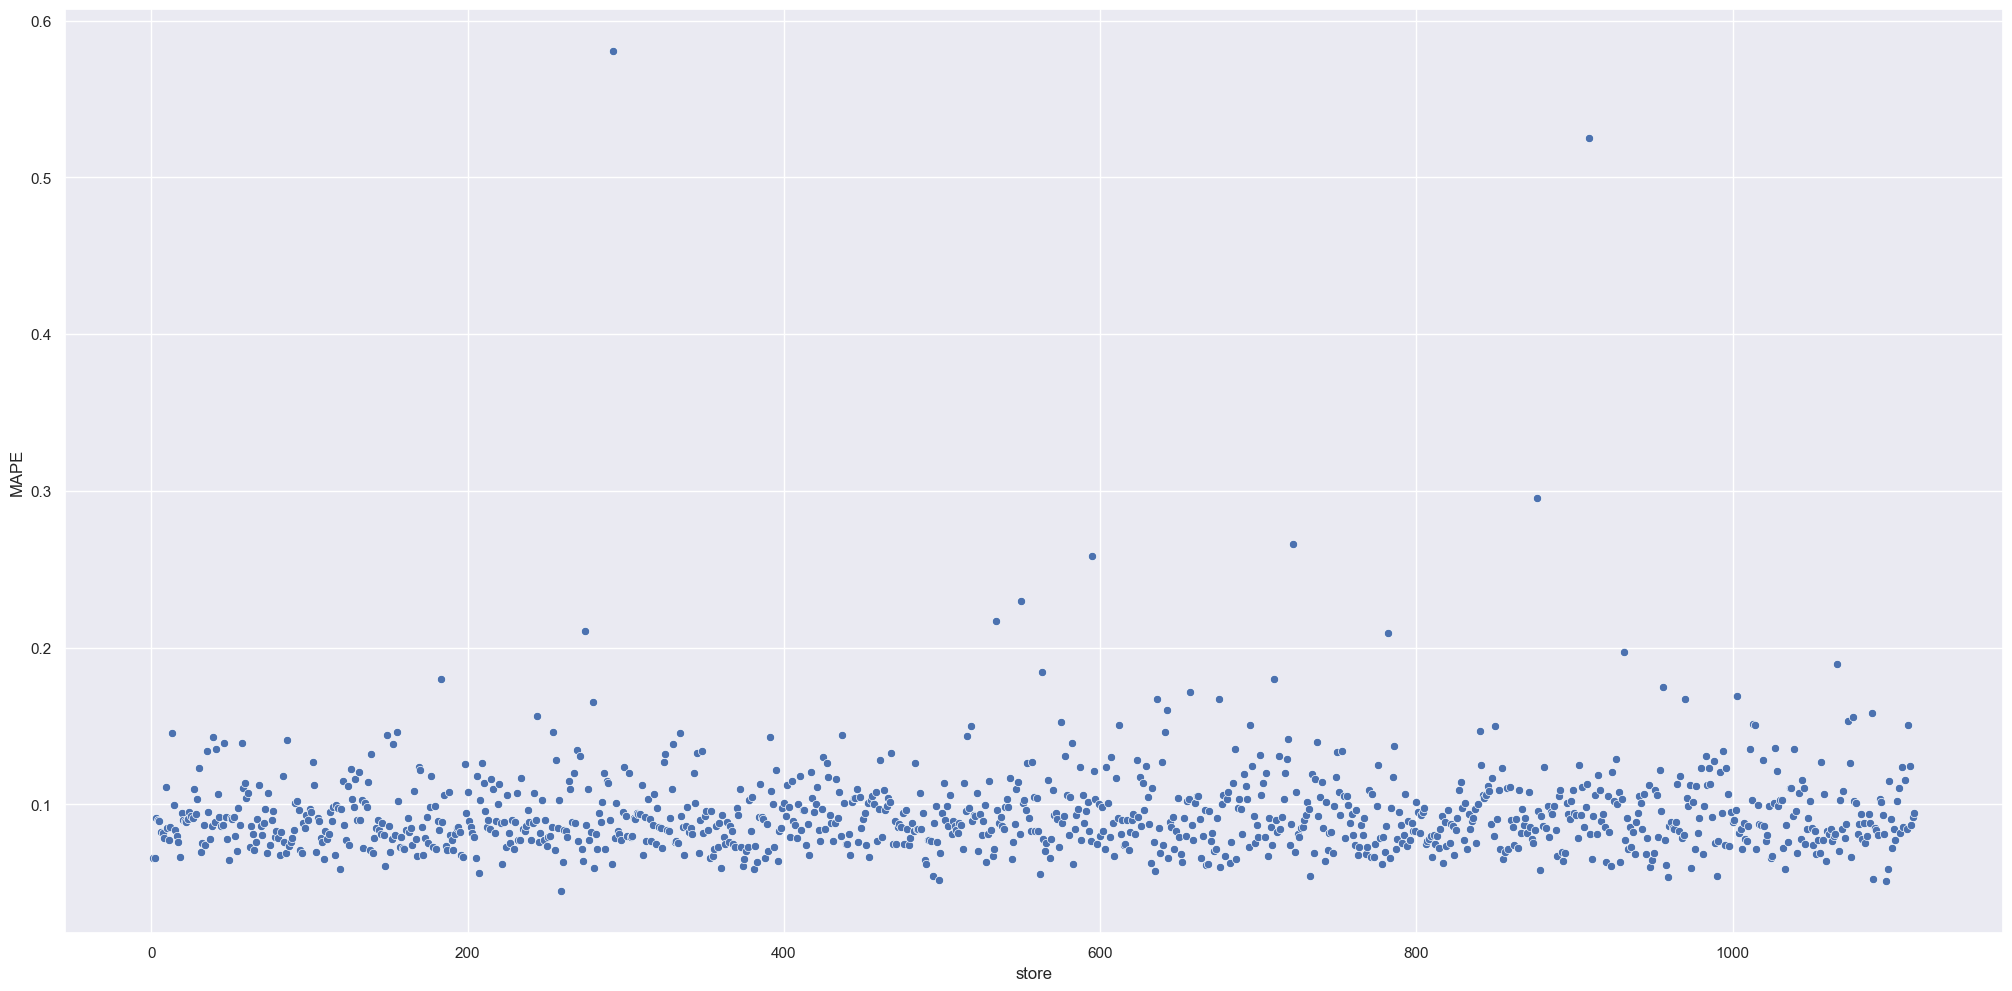

In [123]:
sns.scatterplot(x='store', y='MAPE',data=df92)

## 9.2. Total Performance

In [124]:
df93 = df92[['predictions','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0 ).reset_index().rename(columns={'index': 'Cenario',0:'Valores'})

df93['Valores'] = df93['Valores'].map('R${:,.2f}'.format)
df93





,Cenario,Valores
0,predictions,"R$287,959,008.00"
1,worst_scenario,"R$287,239,995.05"
2,best_scenario,"R$288,678,029.04"


## 9.3 Machine Learning Performance

In [125]:
df9['error'] = df9['sales']- df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']



<Axes: xlabel='predictions', ylabel='error'>

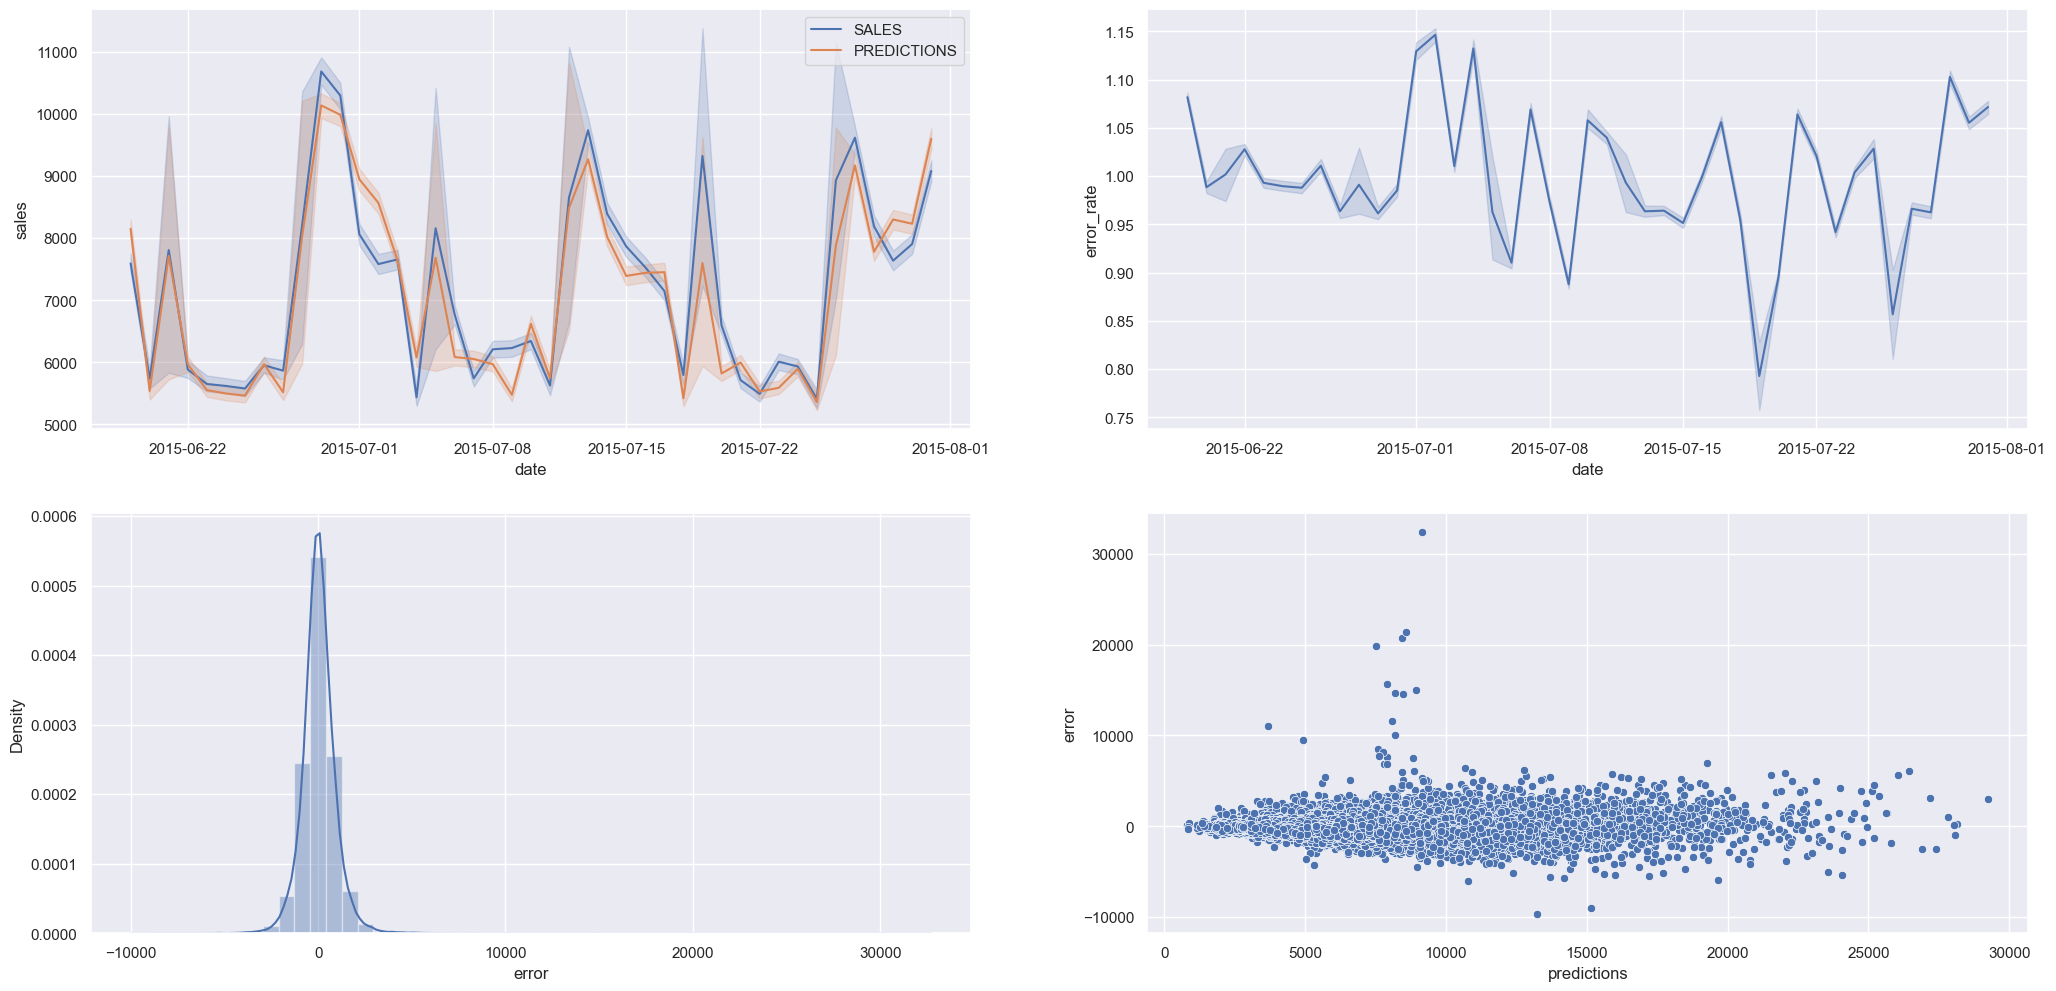

In [126]:
pt.subplot(2,2,1)
sns.lineplot(x ='date' , y='sales', data=df9 , label='SALES')
sns.lineplot(x = 'date', y='predictions', data=df9, label='PREDICTIONS')

pt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

pt.subplot(2,2,3)
sns.distplot(df9['error'])

pt.subplot(2,2,4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

In [127]:
df9.dtypes

store                                    int64
promo                                    int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
competition_time_mont                  float64
promo_time_week                        float64
day_of_week_sin                        float64
day_of_week_cos                        float64
month_cos                              float64
day_sin                                float64
day_cos                                float64
week_of_year_cos                       float64
date                            datetime64[ns]
sales                                  float64
predictions                            float32
error        

# 10.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [128]:
#Modelo salvo 
#pickle.dump( model_xgb_tuned,open('/home/leticia/Documentos/comunidade_ds/ds_producao/Notebook/model_rossmann.pkl', 'wb'))



## 10.1. Rossmann Class

In [129]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math 
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler  = pickle.load( open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/competition_distance_scaler.pkl','rb') )
        self.competition_time_mont_scaler = pickle.load( open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/competition_time_mont_scaler.pkl','rb') )
        self.promo_time_week_scaler       = pickle.load( open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/promo_time_week_scaler.pkl','rb') )
        self.year_scaler                  = pickle.load( open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/year_scaler.pkl','rb') )
        self.store_type_scaler            = pickle.load( open('/home/leticia/Documentos/comunidade_ds/ds_producao/paramenter/store_type_scaler.pkl','rb'))
   
    
    def data_cleaning(self, df1):
        #rename columns
        
        cols_old =['Store', 'DayOfWeek', 'Date','Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                   'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                   'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        snakecase =lambda x : inflection.underscore(x)

        cols_new = list (map (snakecase, cols_old) )

        #rename
        df1.columns=cols_new


        #transformando a coluna de 'date' no formato de date
        df1['date']=pd.to_datetime(df1['date'])


        ## Fillout NA

        #competition_distance (distância mais  proxima da concorrência )
        #(se eu não tenho dados quer dizer que meu competidor mais próximo é muito distante , então eu posso colocar um valor max)

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month  
        #coloco o axis=1 porque estou percorrendo mais de uma coluna 
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year   
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval                
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map']= df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0 , axis=1)

        #tranformando numero float para inteiros 
        #competition_open_since_month  
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

        #competition_open_since_year

        df1['competition_open_since_year'] = df1 ['competition_open_since_year'].astype(int)

        #promo2_since_week 
        df1['promo2_since_week'] =  df1['promo2_since_week'].astype(int)

        #promo2_since_year
        df1['promo2_since_year'] = df1 ['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self , df2):
        # year
        df2['year']= df2['date'].dt.year

        # month
        df2['month']= df2['date'].dt.month

        # day
        df2['day']= df2['date'].dt.day

        # week of year
        df2['week_of_year']= df2['date'].dt.isocalendar().week

        # year week

        df2['year_week']= df2['date'].dt.strftime('%Y-%W')

        # competition since( tenho o mês e o ano separado vou ter que unir )

        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day = 1), axis = 1)
        df2['competition_time_mont']= ((df2['date']- df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x + '-1','%Y-%W-%w') - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x == 'b'  else  'extended')

        #stateHoliday

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day'   )

        #filtragens da linhas
        df2 = df2[(df2['open'] != 0) ]
        
        #Seleção de Colunas 
        cols_drop =['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5,):
              
        #rescaling 
        #competition_distance (Robust Scarler )
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
       
        #competition_time_mont(Robust Scarler )

        df5['competition_time_mont'] = self.competition_time_mont_scaler.fit_transform( df5[['competition_time_mont']].values )
        
        #promo_time_week(Min-Max)
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
      

        #year (Min-Max)
        df5['year'] =self.year_scaler.fit_transform( df5[['year']].values )
       
             
        
        ## Encoding
        #state_holiday- Onde Hot Encoding
        df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

        #store_type - Label Encoding- não tem tipo de relação 

        
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
       
        #assortment - Ordinal Encoding- tem um tipo de relação
        # Fazer o dicionario para colocar a importancia de cada um.
        assortment_dict = {'basic': 1,'extra': 2,'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2.* np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2.* np.pi/7 ) ) )

        #month 
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2.* np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2.* np.pi/12 ) ) )  

        #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2.* np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2.* np.pi/30) ) )

        #week_of_year 
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/53 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/53 ) ) )
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance', 'competition_open_since_month','competition_open_since_year',
                          'promo2','promo2_since_week','promo2_since_year','competition_time_mont','promo_time_week','day_of_week_sin','day_of_week_cos',
                          'month_cos','day_sin','day_cos','week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        pred = model.predict( test_data )
        original_data['prediction'] = np.expm1( pred )
     
        return original_data.to_json( orient='records', date_format='iso' )
    
    
        
        
        

    


## 10.2. API Handler

In [130]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from rossmann.Rossmann import Rossmann

# # loading model
# model = pickle.load( open( '/home/leticia/Documentos/comunidade_ds/ds_producao/Notebook/model/model_rossmann.pkl', 'rb'))

#  # initialize API
# app=Flask(__name__)

# @app.route( '/rossmann/predict', methods=['POST'] )
# def rossmann_predict():
#     test_json = request.get_json()
   
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # Instantiate Rossmann class
#         pipeline = Rossmann()
        
#         # data cleaning
#         df1 = pipeline.data_cleaning( test_raw )
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( df1 )
        
#         # data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
        
        
#     else:
#         return Reponse( '{}', status=200, mimetype='application/json' )

# if __name__ == '__main__':
#     app.run( '0.0.0.0' )

## 10.3. API Tester

In [131]:
import requests

In [132]:
#loading dataset
df10=pd.read_csv('/home/leticia/Documentos/comunidade_ds/ds_producao/data/test.csv')


In [133]:
#merge test dataset +store
df_test = pd.merge(df10,df_store, how='left', on='Store')

#chose store for predict
df_test= df_test[df_test['Store'].isin([24,12,22]) ]
#remove cloased days 
df_test  = df_test[df_test['Open'] != 0]
df_test  = df_test[~df_test['Open'].isnull()]
df_test =  df_test.drop( 'Id', axis=1 )



In [134]:
df_test.head(4)

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
7,12,4,2015-09-17,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
17,24,4,2015-09-17,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
863,12,3,2015-09-16,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [135]:
#convertendo o datafreme em uma liguaguem comum para os dois sitemas , tansformando em to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
#API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://teste-rossmann-api-ihe9.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }

data = data

r = requests.post(url, data=data, headers = header )
print('Status Code{}'.format(r.status_code))



In [ ]:
d1=pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d1.head(4)

In [ ]:
d2= d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('Store Number{} will sell R$ {:,.2f} in the next 6 weeks'.format(
           d2.loc[i,'store'],
           d2.loc[i, 'prediction'] ) )

In [ ]:
d2